# Regular Genomics Project **RNA Localisation**


---

**Problem definition**:

TODO


In [ ]:
# Inline installation instructions: 
# ! ONLY EXECUTE WHEN IN COLAB !
#############################

%pip install pandas
%pip install torch
%pip install numpy
%pip install keras
%pip install tensorflow
%pip install matplotlib
%pip install scikit-learn
%pip install pydot

##############################

### **1.** First steps with data

Firstly, we import several necessary packages and load in our data:

In [1]:
import pandas as pd
import numpy as np
#from keras.utils import to_categorical
from keras.utils import to_categorical
import itertools
from collections import OrderedDict
import os
import sys
#from keras.utils import pad_sequences
from keras.utils import pad_sequences
import tensorflow
from sklearn.model_selection import KFold, StratifiedKFold
from dataloaders.GeneWrapper import Gene_Wrapper
from sklearn.model_selection import train_test_split
#from plotting import plot_line_graph, box_plot, multiplot_pearson
from utils import read_model_file
import matplotlib.pyplot as plt


2023-07-12 10:18:29.945362: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 10:18:32.405715: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 10:18:32.410916: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 10:18:38.502928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Defining a few parameters
max_len = 34526
nb_filters = 32
filters_length = 10
pooling_size = 3
lstm_units = 32
lower_bound = 0
upper_bound = 4000
nb_classes = 9 # because we have 9 localisations
batch_size = 256

output_path = "/outputs" #"~/Downloads/model_outputs"
model_architecture_path = "model_architecture_viz/simple_cnn.png"

In [3]:
# Initializing test set

colab = False  #### Set colab flag ####

if colab:
    np.random.seed(3)
    url = 'https://www.dropbox.com/s/0r8nmwbthhkf2zi/seq_from_prim_and_icshape_withchrm_no_scaff.csv?dl=1' #'https://www.dropbox.com/s/hv4uau8q4wwg00k/final_data.csv?dl=1'
    data_org = pd.read_csv(url)
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index)
else:
    np.random.seed(3)
    data_org = pd.read_csv('~/Downloads/final_data.csv')
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index) # TODO: note: we also have to preprocess the test set similary
    # TODO: colab

data_org

ERM       KDEL        LMA       MITO        NES        NIK  \
0      57.045409  35.456782  22.008215  12.355106  22.789983  24.241731   
1       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2      17.449430  34.151539  29.338431  22.237585  24.682767  43.612551   
3       3.830180   2.576734   5.737850   0.761343   2.786808   2.784356   
4      13.132915   8.782925  10.061390   3.012459   8.821250   6.721117   
...          ...        ...        ...        ...        ...        ...   
13805   0.000000   0.000000   0.506809   0.075893   0.050764   0.000000   
13806   0.105452   0.087130   0.171187   0.016101   0.079057   0.669947   
13807   0.037093   0.444844   0.425368   0.254467   0.323794   1.803249   
13808   0.000000   0.519421   2.119115   0.360450   0.887939   0.345021   
13809   0.000000   0.226187   0.000000   0.032740   0.157772   0.000000   

             NLS       NUCP        OMM          gene_id    gene_biotype  \
0      16.970436  29.348389  54.916891  ENSG00000000003  protein_coding   
1       0.000000   2.914814   0.244517  ENSG00000000005  protein_coding   
2      38.683963  35.678476  25.348560  ENSG00000000419  protein_coding   
3       3.382682   2.463676   2.819269  ENSG00000000457  protein_coding   
4      10.827253   8.005113   6.849962  ENSG00000000460  protein_coding   
...          ...        ...        ...              ...             ...   
13805   0.056586   0.000000   0.000000  ENSG00000281883  protein_coding   
13806   0.171672   0.000000   0.254546  ENSG00000282034  protein_coding   
13807   1.435483   0.249590   0.483645  ENSG00000282827  protein_coding   
13808   1.274465   0.741954   0.460649  ENSG00000282936  protein_coding   
13809   0.301875   0.000000   0.016665  ENSG00000282988  protein_coding   

                                                     seq  \
0      ACCTTGTATTAGGTATTTATTTCCACAAAAGTTTGATGCTTACAAC...   
1      TGTGCACAGAAGTTATATACATATATGGGTATATCTATGTAACAAA...   
2      TACTTTATGCAAAAAAAAATATACATTTATTTATAGGTCTCAATAC...   
3      TGACTTTCAAACCATTTTAATATTTCAAATATTCCAGAACAATCCC...   
4      AACCCGCTCGGGTCCCCTTCCACACTGTGGAAGCTTTGTTCTTTCG...   
...                                                  ...   
13805  GGGAAGAAAGGAGCCTGACTCTTATGATGGAATAACCACAAATCAG...   
13806  GTGTCGGACGGCATGACAGGCAGCAATCCTGTGTCCCCTGCCTCAT...   
13807  ATGGCGGGGACCTCCGCGCCAGGCAGCAAGAGGCGGAGCGAGCCCC...   
13808  CTACTGGAACGCCCCCCTCAATCTAGCCTCCCCCACATAACTCTCT...   
13809  TGGTCTATCTCCCAAGTCAAAGACTGAAGTAAAGAAAAAGGTTGCA...   

                                                  struct  m6A_5UTR  m6A_CDS  \
0      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         0        0   
1      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         0        0   
2      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         0        0   
3      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         0        9   
4      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         0        0   
...                                                  ...       ...      ...   
13805  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         0        2   
13806  [0.37599998712539673, 0.0, 0.07500000298023224...         0       66   
13807  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         0        0   
13808  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         0        0   
13809  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         0        0   

       m6A_3UTR  
0             1  
1             0  
2             0  
3             5  
4             2  
...         ...  
13805         1  
13806         4  
13807         0  
13808         2  
13809         0  

[13810 rows x 16 columns]

In [4]:

sum_vec = train_data.iloc[:, :9].sum(axis=1)
data2 = train_data.iloc[:, :9].divide(sum_vec, axis='index')
train_data_no_struct = pd.concat([data2, train_data['seq']], axis=1)
train_data_no_struct



ERM      KDEL       LMA      MITO       NES       NIK       NLS  \
0      0.207338  0.128871  0.079991  0.044906  0.082833  0.088109  0.061681   
1      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2      0.064346  0.125935  0.108187  0.082002  0.091019  0.160823  0.142649   
3      0.141112  0.094932  0.211394  0.028049  0.102672  0.102581  0.124625   
4      0.172315  0.115240  0.132014  0.039526  0.115743  0.088187  0.142063   
...         ...       ...       ...       ...       ...       ...       ...   
13805  0.000000  0.000000  0.734451  0.109981  0.073566  0.000000  0.082002   
13806  0.067811  0.056029  0.110082  0.010354  0.050838  0.430809  0.110393   
13807  0.006797  0.081510  0.077941  0.046627  0.059330  0.330415  0.263028   
13808  0.000000  0.077421  0.315861  0.053726  0.132350  0.051426  0.189963   
13809  0.000000  0.307638  0.000000  0.044530  0.214586  0.000000  0.410580   

           NUCP       OMM                                                seq  
0      0.106670  0.199601  ACCTTGTATTAGGTATTTATTTCCACAAAAGTTTGATGCTTACAAC...  
1      0.922605  0.077395  TGTGCACAGAAGTTATATACATATATGGGTATATCTATGTAACAAA...  
2      0.131566  0.093474  TACTTTATGCAAAAAAAAATATACATTTATTTATAGGTCTCAATAC...  
3      0.090767  0.103868  TGACTTTCAAACCATTTTAATATTTCAAATATTCCAGAACAATCCC...  
4      0.105034  0.089878  AACCCGCTCGGGTCCCCTTCCACACTGTGGAAGCTTTGTTCTTTCG...  
...         ...       ...                                                ...  
13805  0.000000  0.000000  GGGAAGAAAGGAGCCTGACTCTTATGATGGAATAACCACAAATCAG...  
13806  0.000000  0.163685  GTGTCGGACGGCATGACAGGCAGCAATCCTGTGTCCCCTGCCTCAT...  
13807  0.045733  0.088620  ATGGCGGGGACCTCCGCGCCAGGCAGCAAGAGGCGGAGCGAGCCCC...  
13808  0.110591  0.068661  CTACTGGAACGCCCCCCTCAATCTAGCCTCCCCCACATAACTCTCT...  
13809  0.000000  0.022666  TGGTCTATCTCCCAAGTCAAAGACTGAAGTAAAGAAAAAGGTTGCA...  

[12429 rows x 10 columns]

In [5]:

# One hot encode the 'seq' attribute of the above table
mapping = {
    'A': 0,
    'C': 1,
    'G': 2,
    'T': 3
}

mapping_localisations = {
    'ERM':  0,
    'KDEL': 1,
    'LMA':  2,
    'MITO': 3,
    'NES':  4,
    'NIK':  5,
    'NLS':  6,
    'NUCP': 7,
    'OMM':  8
}

one_hot_encode_lam = lambda seq: to_categorical([mapping[x] for x in seq])
data_one = train_data_no_struct['seq'].apply(one_hot_encode_lam)

data_one

# Now just injecting this modified 'seq' back into the pandas frame
data_one_no_struct =  pd.concat([train_data_no_struct.iloc[:, :9], data_one], axis=1)

data_one_no_struct


# Additional ordinal encoding of the 'seq' attribute

gene_data = train_data['seq']

def label_dist(dist):
    # TODO: what is this
    assert (len(dist) == 4)
    return np.array(dist) / np.sum(dist)

encoding_seq = OrderedDict([
    ('UNK', [0, 0, 0, 0]),
    ('A', [1, 0, 0, 0]),
    ('C', [0, 1, 0, 0]),
    ('G', [0, 0, 1, 0]),
    ('T', [0, 0, 0, 1]),
    ('N', [0.25, 0.25, 0.25, 0.25]),  # A or C or G or T
])

encoding_keys = list(encoding_seq.keys())
seq_encoding_vectors = np.array(list(encoding_seq.values()))
encoding_vectors = seq_encoding_vectors


In [31]:
#print(mapping_localisations.keys())
#print(list(mapping_localisations.keys()))
#print(data_one_no_struct[mapping_localisations.keys()])
#print(data_one_no_struct[mapping_localisations.keys()].values)

dict_keys(['ERM', 'KDEL', 'LMA', 'MITO', 'NES', 'NIK', 'NLS', 'NUCP', 'OMM'])
['ERM', 'KDEL', 'LMA', 'MITO', 'NES', 'NIK', 'NLS', 'NUCP', 'OMM']
            ERM      KDEL       LMA      MITO       NES       NIK       NLS  \
0      0.207338  0.128871  0.079991  0.044906  0.082833  0.088109  0.061681   
1      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2      0.064346  0.125935  0.108187  0.082002  0.091019  0.160823  0.142649   
3      0.141112  0.094932  0.211394  0.028049  0.102672  0.102581  0.124625   
4      0.172315  0.115240  0.132014  0.039526  0.115743  0.088187  0.142063   
...         ...       ...       ...       ...       ...       ...       ...   
13805  0.000000  0.000000  0.734451  0.109981  0.073566  0.000000  0.082002   
13806  0.067811  0.056029  0.110082  0.010354  0.050838  0.430809  0.110393   
13807  0.006797  0.081510  0.077941  0.046627  0.059330  0.330415  0.263028   
13808  0.000000  0.077421  0.315861  0.053726  0.132350  0.051426

In [6]:

X = pad_sequences([[encoding_keys.index(c) for c in gene] for gene in gene_data],
                    maxlen=max_len,
                    dtype=np.int8, value=encoding_keys.index('UNK'))  # , truncating='post')

y = data_one_no_struct[mapping_localisations.keys()].values

# See notes to extend this for secondary structure

encoding_keys


['UNK', 'A', 'C', 'G', 'T', 'N']

### **2** |  Importing models...

We use as baseline model the [RNATracker](https://github.com/HarveyYan/RNATracker/blob/master/Models/cnn_bilstm_attention.py) model and a CNN model.


In [7]:
# Import NN
from models.RNAtracker import RNATracker
from metrics import pearson, Pearson
# Set paths for model output
try:
    os.makedirs('')
except Exception as e:
    print(str(e))

model_output_folder = output_path #'~/Downloads/model_outputs'
epochs = 15

list_indizes = [i for i in range(X.shape[0])]
list_indizes

[Errno 2] No such file or directory: ''


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [8]:

# TODO: with understand what we have to predict, we can allocate X and y
# Also: the kwargsvalues are hyperparameters of which we will select default values from the RNAtracker repo


train_indices, test_indices = train_test_split(list_indizes, random_state=42, test_size=0.2)

model = RNATracker(max_len, nb_classes, model_output_folder, kfold_index=0)
#model.build_model(nb_filters=kwargs['nb_filters'], filters_length=kwargs['filters_length'],
#                          pooling_size=kwargs['pooling_size'], lstm_units=kwargs['lstm_units'],
#                          embedding_vec=encoding_vectors)
model.pearson_attr = pearson
model.pearson_class_attr = Pearson(name="class_pearson", return_dict=True)
model.pearson_class_attr_no_dict = Pearson(name="class_nodict_pearson", return_dict=False)
model.build_model_advanced_masking(nb_filters=nb_filters,
                                                filters_length=filters_length,
                                                pooling_size=pooling_size,
                                                lstm_units=lstm_units,
                                                embedding_vec=encoding_vectors)

Advanced Masking
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 34526)]      0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34526, 4)     24          ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 34517, 32)    1280        ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 11505, 32)    0           ['conv1d[0][0]']                 
                                                                             

In [ ]:




model.train(X[train_indices], y[train_indices], batch_size,epochs)



history = model.stored_history



In [9]:
#model.print_model(model_architecture_path)
import datetime
import pydot
time_date = datetime.datetime.now().date()
# time_hour = datetime.datetime.now().time()

model_output = f"model_outputs/simple_cnn_{time_date}.h5"

model.save_model(model_output)

In [ ]:

try:
    plt_data = [history.history['loss'], history.history['val_loss']]
    plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['train', 'val'])
except Exception as p:
    pass

try:
    plt_data = [history.history['pearson'], history.history['val_pearson']]
    plot_line_graph(plt_data, "Correlation Graph", 'correlation', 'epoch', ['train', 'val'])
except Exception as p:
    pass

try:
    plt_data = [history.history['class_pearson'], history.history['val_class_pearson']]
    plot_line_graph(plt_data, "class_pearson Graph", 'class_pearson', 'epoch', ['train', 'val'])
except Exception as p:
    pass

try:
    plt_data = [history.history['class_nodict_pearson'], history.history['val_class_nodict_pearson']]
    plot_line_graph(plt_data, "class_nodict_pearson Graph", 'class_nodict_pearson', 'epoch', ['train', 'val'])
except Exception as p:
    pass

try:
    plt_data = [history.history['accuracy'], history.history['val_accuracy']]
    plot_line_graph(plt_data, "accuracy Graph", 'accuracy', 'epoch', ['train', 'val'])
except Exception as p:
    pass

try:
    plt_data = [history.history['acc'], history.history['val_acc']]
    plot_line_graph(plt_data, "accuracy Graph", 'accuracy', 'epoch', ['train', 'val'])
except Exception as p:
    pass

try:
    plt_data = [history.history['kullback_leibler_divergence'], history.history['val_kullback_leibler_divergence']]
    plot_line_graph(plt_data, "kullback_leibler_divergence Graph", 'kullback_leibler_divergence', 'epoch', ['train', 'val'])
except Exception as p:
    pass
try:
    multiplot_pearson(history.history)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
except Exception as p:
    pass



In [ ]:
box_plot(train_data)

In [ ]:

a = model.evaluate(X[test_indices], y[test_indices], "")
print(str(a))
model_output_path = os.path.join(model_output_folder, "modelRNAtracker")
model.save(model_output_path)

#results = model.evaluate(eval_data=train_data.iloc[valid_split], **param_dataLoader_valid)
#results = dict(zip(model.model.metrics_names, results))

#VALIDATION_ACCURACY.append(results['accuracy'])
#VALIDATION_LOSS.append(results['loss'])
#K.clear_session()



In [ ]:
#test_result = model.evaluate(test_data, **param_dataLoader_valid)
#result = dict(zip(model.model.metrics_names, test_result))
#TEST_ACCURACY = result['accuracy']
#TEST_LOSS = result['loss']

In [10]:
import numpy as np
from tensorflow import keras
from motif_search.motif_utilities import plot_weights
path = "/home/steve/Documents/main_storage/resource_data/tep/outputsweights_rnatracker_almost15epochs.h5"

In [14]:
# Load your trained model
#path = '/content/gdrive/MyDrive/Uni/Machine Learning in Regulatory Genomics/scripte/models/'
#model = keras.models.load_model(path)  #(path + 'moitfTest3.keras')
model.model.load_weights(path)
max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()
param_dataLoader_valid = {
    'padding_length': max_seq_len,
    'batch_size': 32,
    'shuffle': False,
    'struct': True
}
pred = model.model.predict(X[train_indices])


2023-07-12 10:25:37.499780: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 343292018 exceeds 10% of free system memory.
2023-07-12 10:25:39.087282: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 141381632 exceeds 10% of free system memory.


  1/311 [..............................] - ETA: 8:50

2023-07-12 10:25:39.487136: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 141381632 exceeds 10% of free system memory.


  2/311 [..............................] - ETA: 1:31

2023-07-12 10:25:39.782014: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 141381632 exceeds 10% of free system memory.


311/311 [==============================] - 113s 361ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [16]:
print(y[train_indices][2, :])
print(pred[2])
model.summary()



[0.07015411 0.15294553 0.11460097 0.10889949 0.11192522 0.0902819
 0.13851156 0.12239186 0.09028936]
[0.10274157 0.11842403 0.12879135 0.06944196 0.1174325  0.10352357
 0.12254201 0.12304754 0.11405557]


AttributeError: 'RNATracker' object has no attribute 'summary'

In [18]:
conv_layer = model.model.get_layer('conv1d')  # Replace 'conv1d' with the actual name of your convolutional layer
weights = conv_layer.get_weights()[0]

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


(10, 4, 32)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

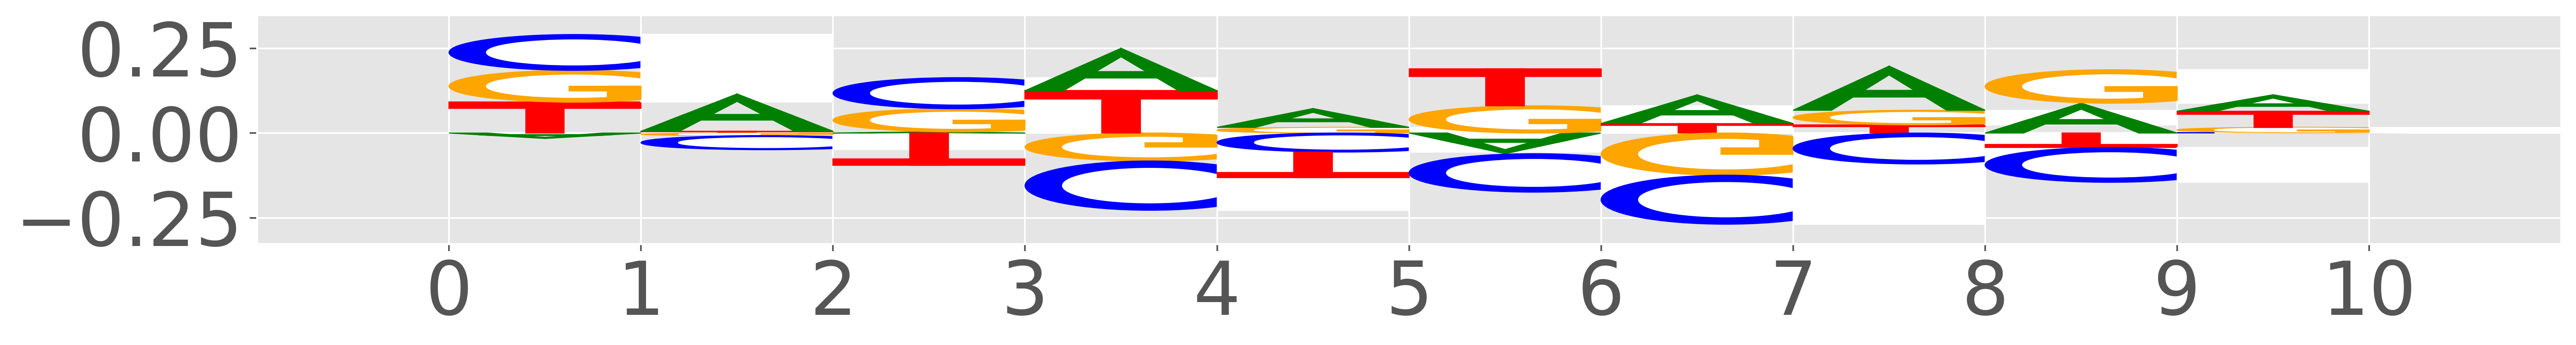

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

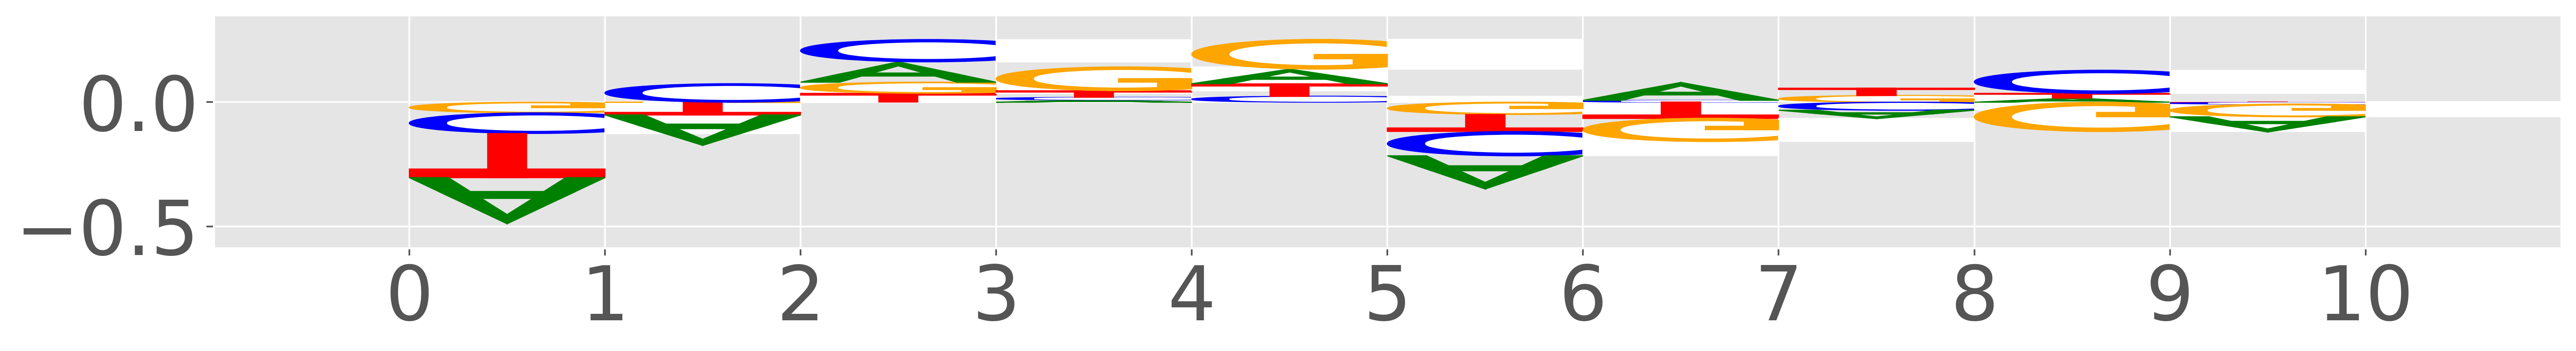

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

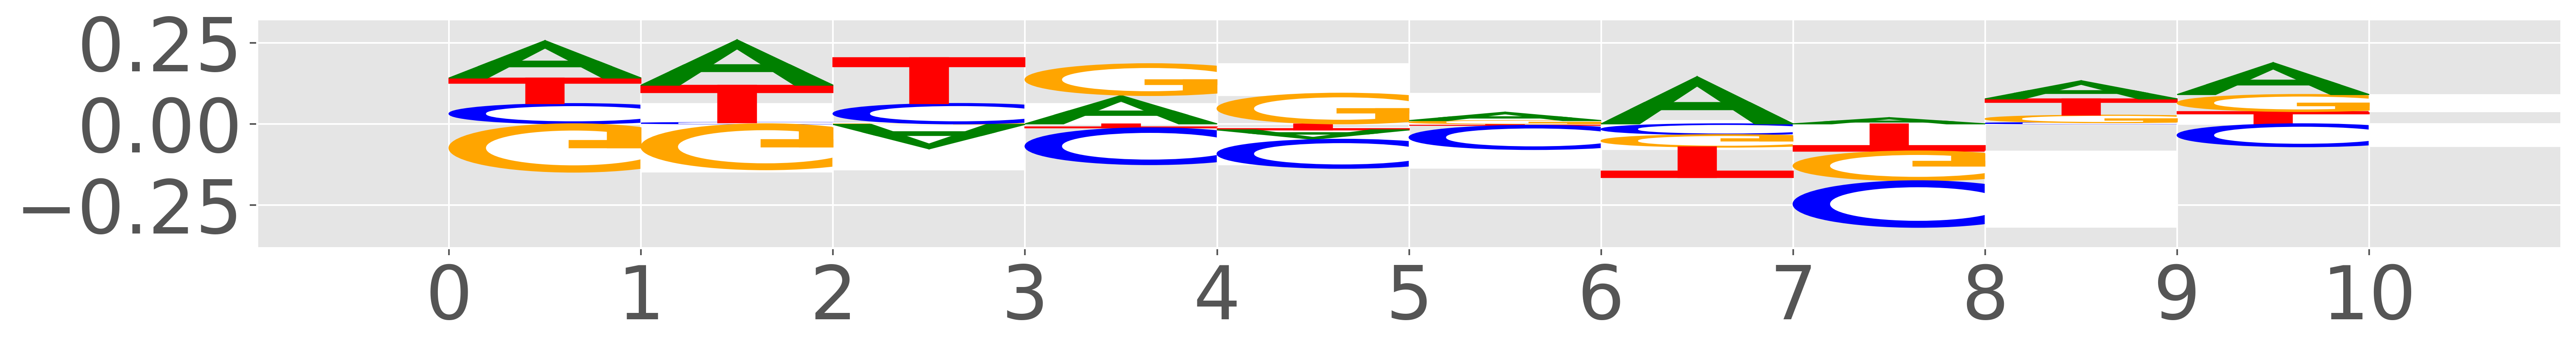

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

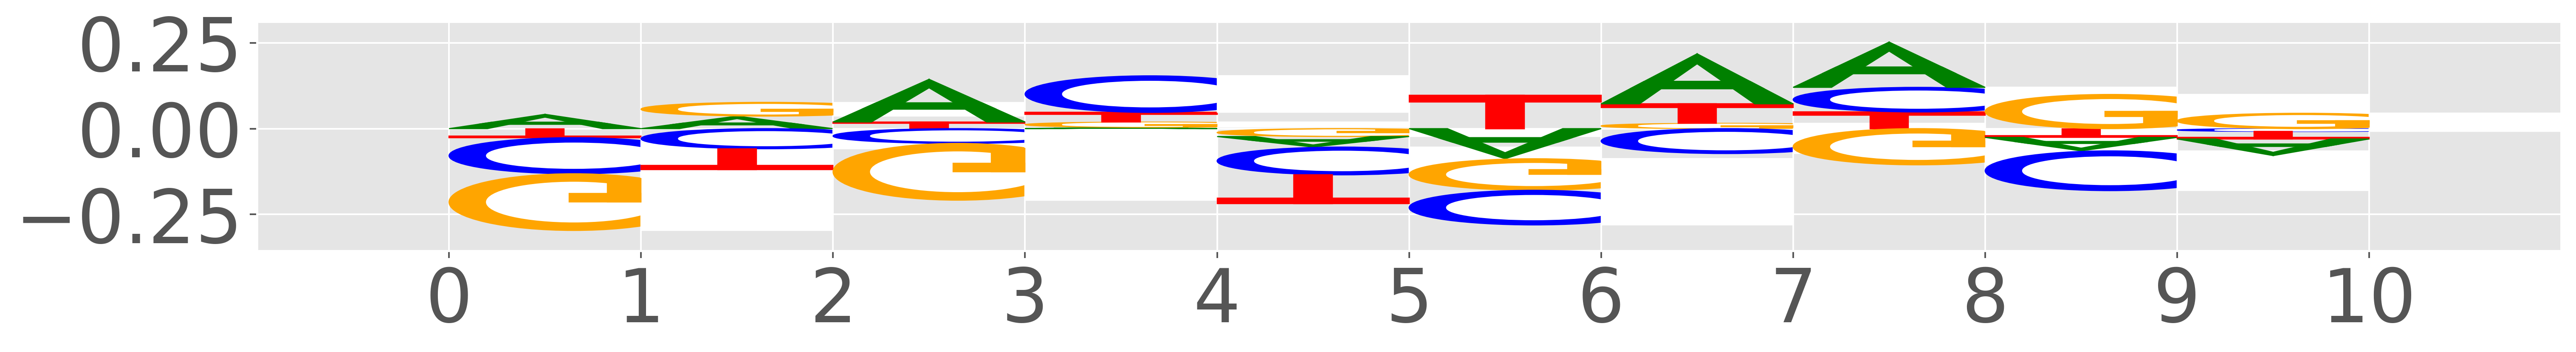

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

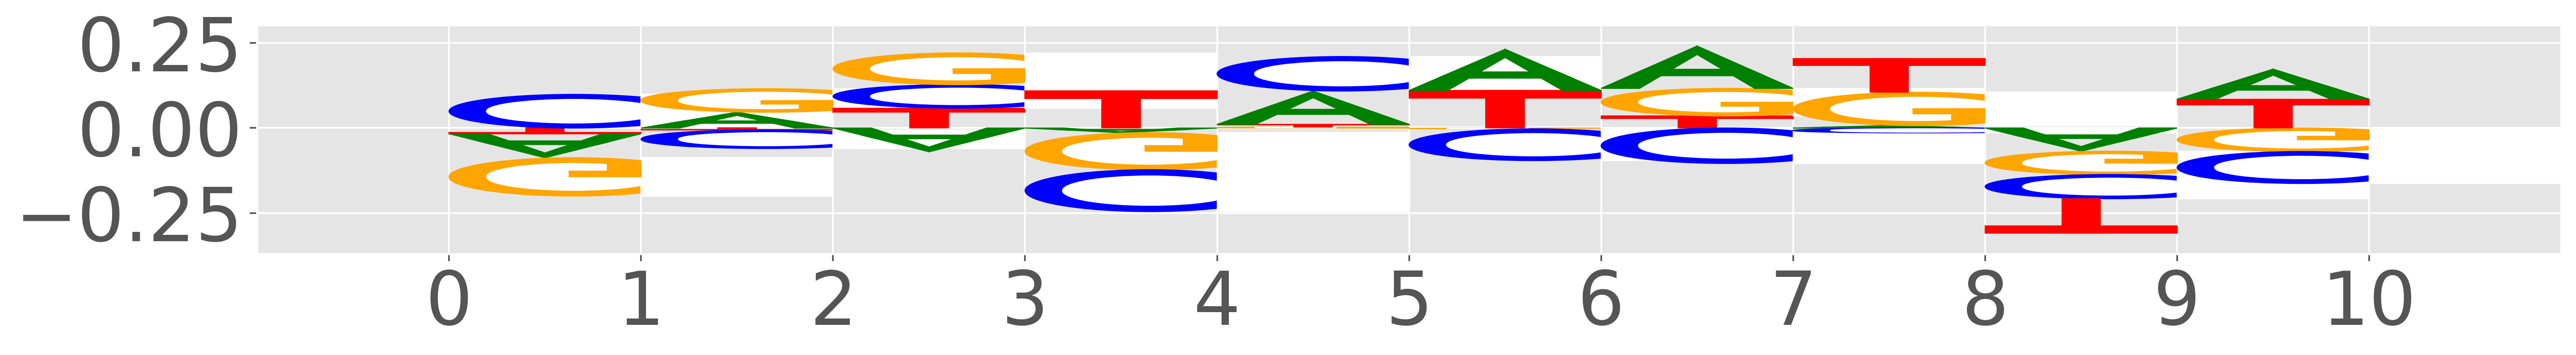

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

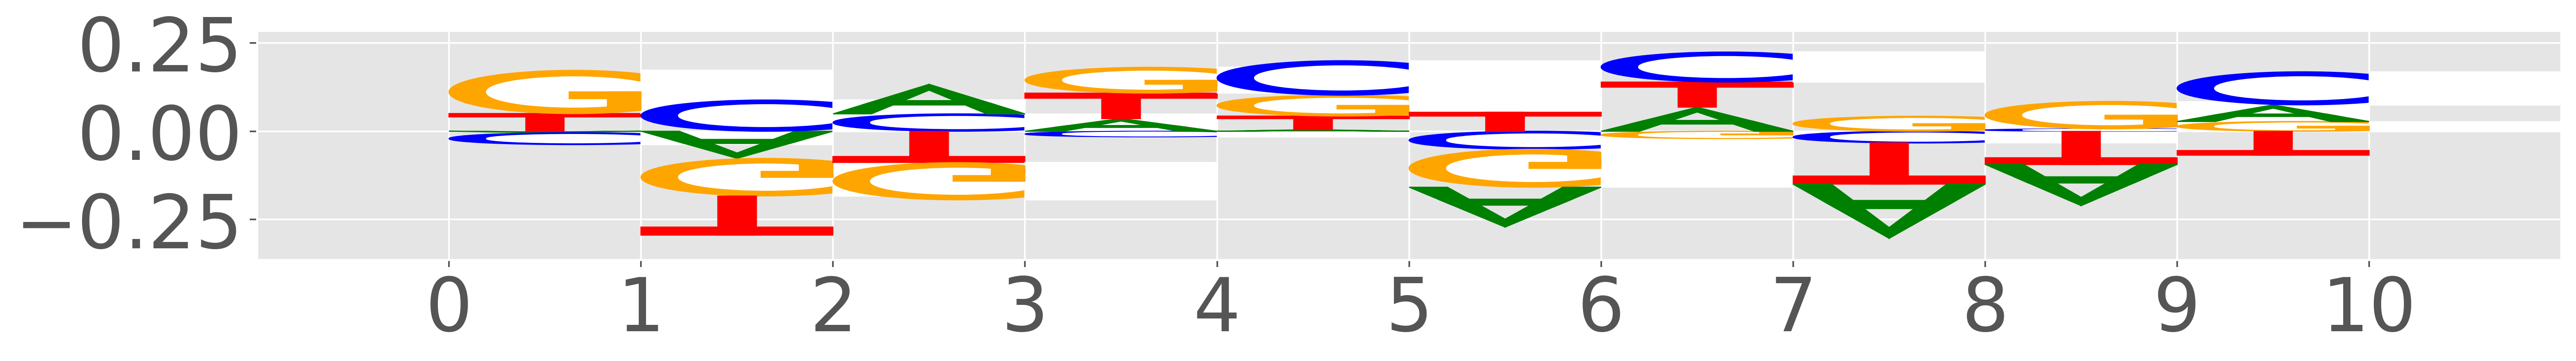

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

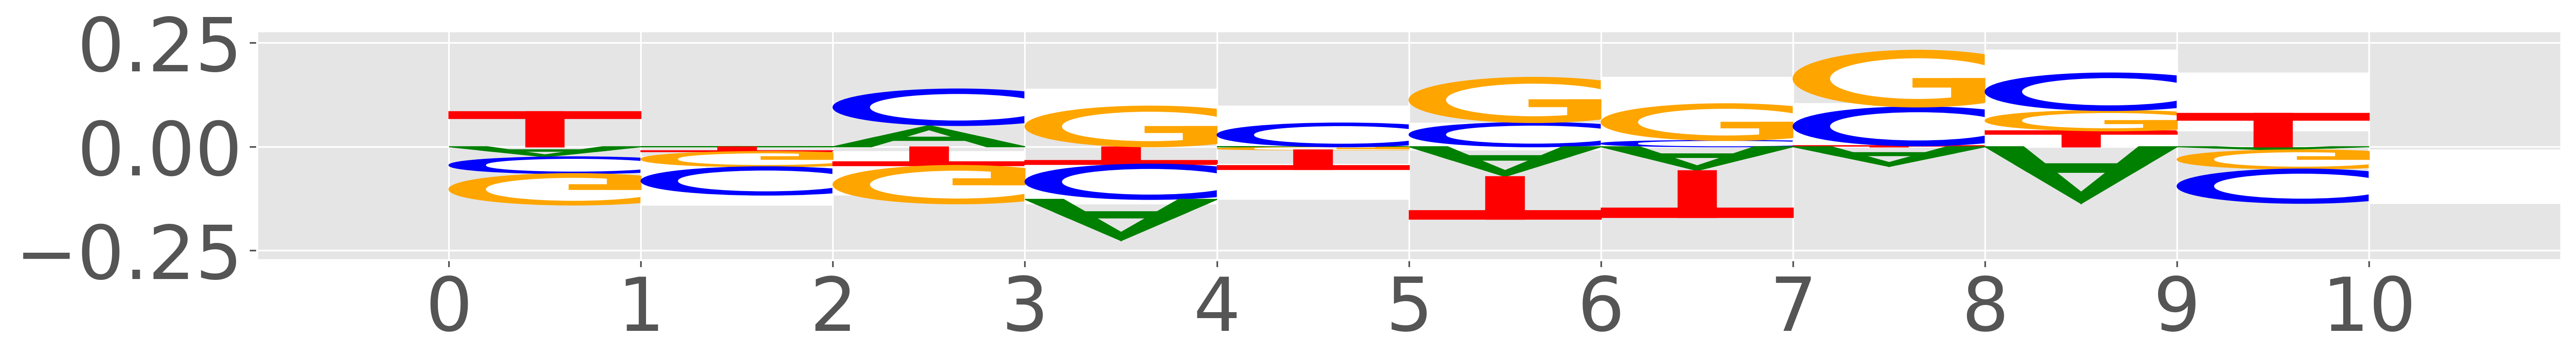

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

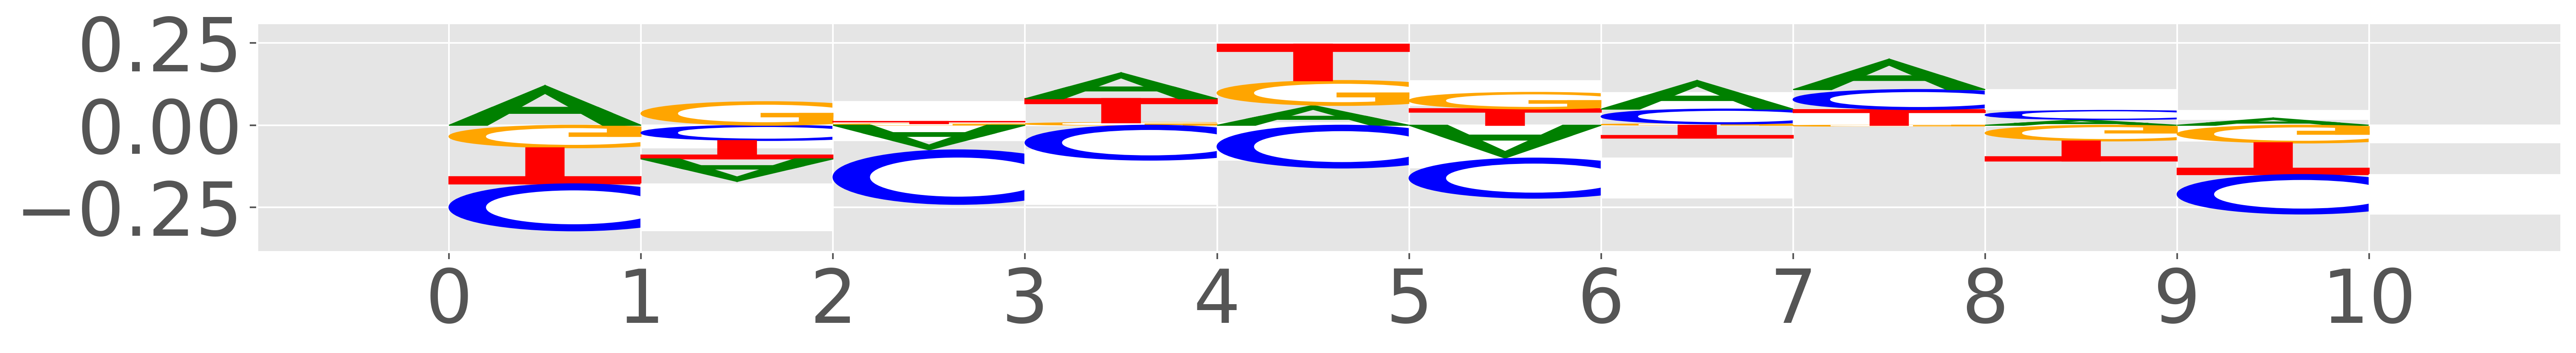

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

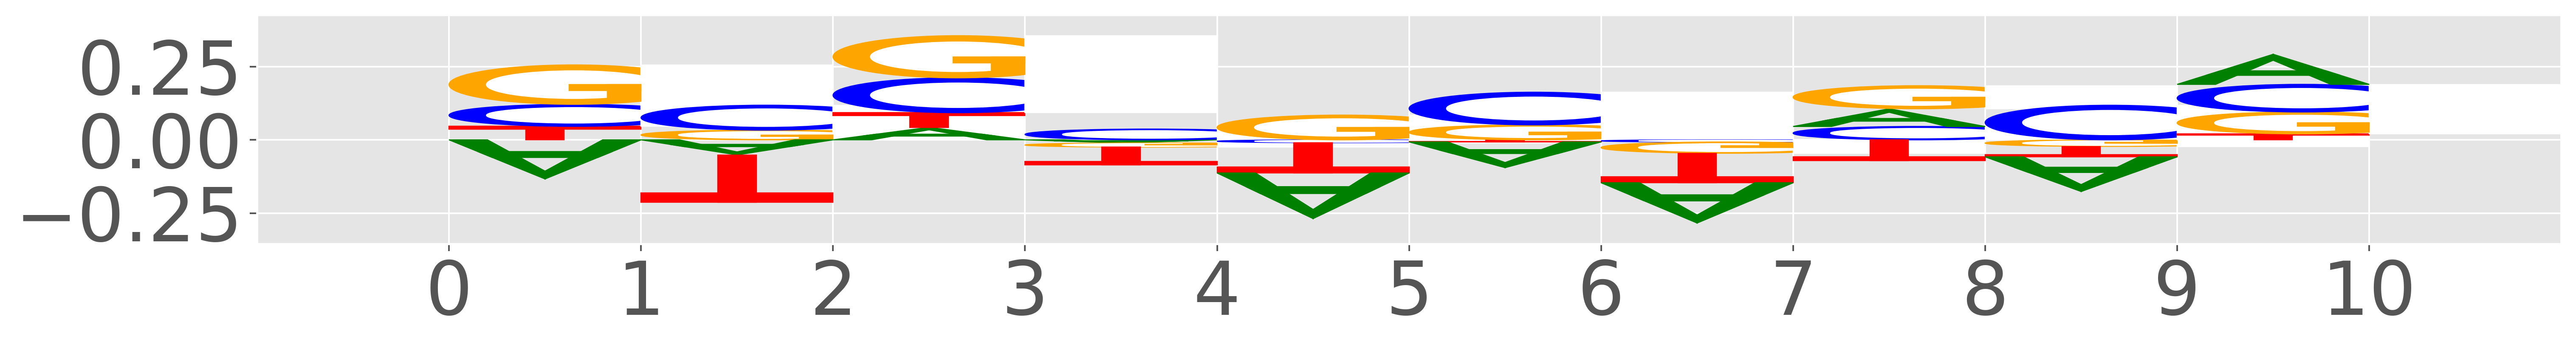

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

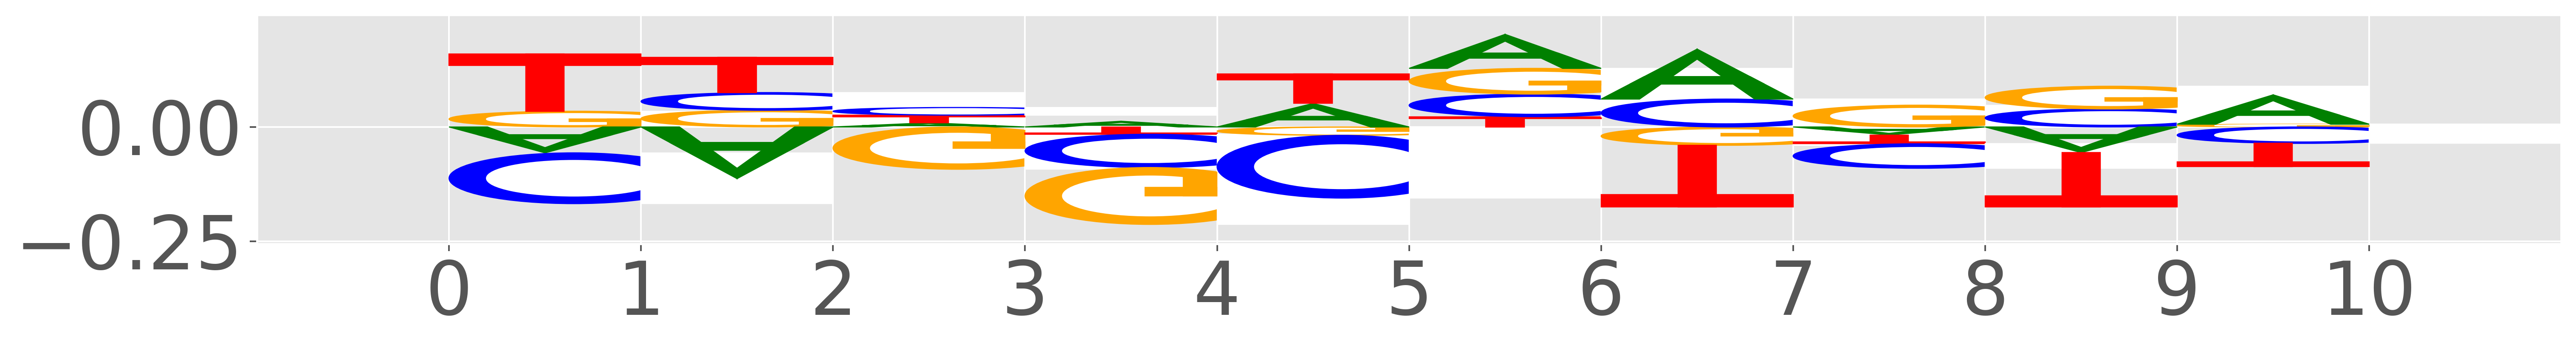

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

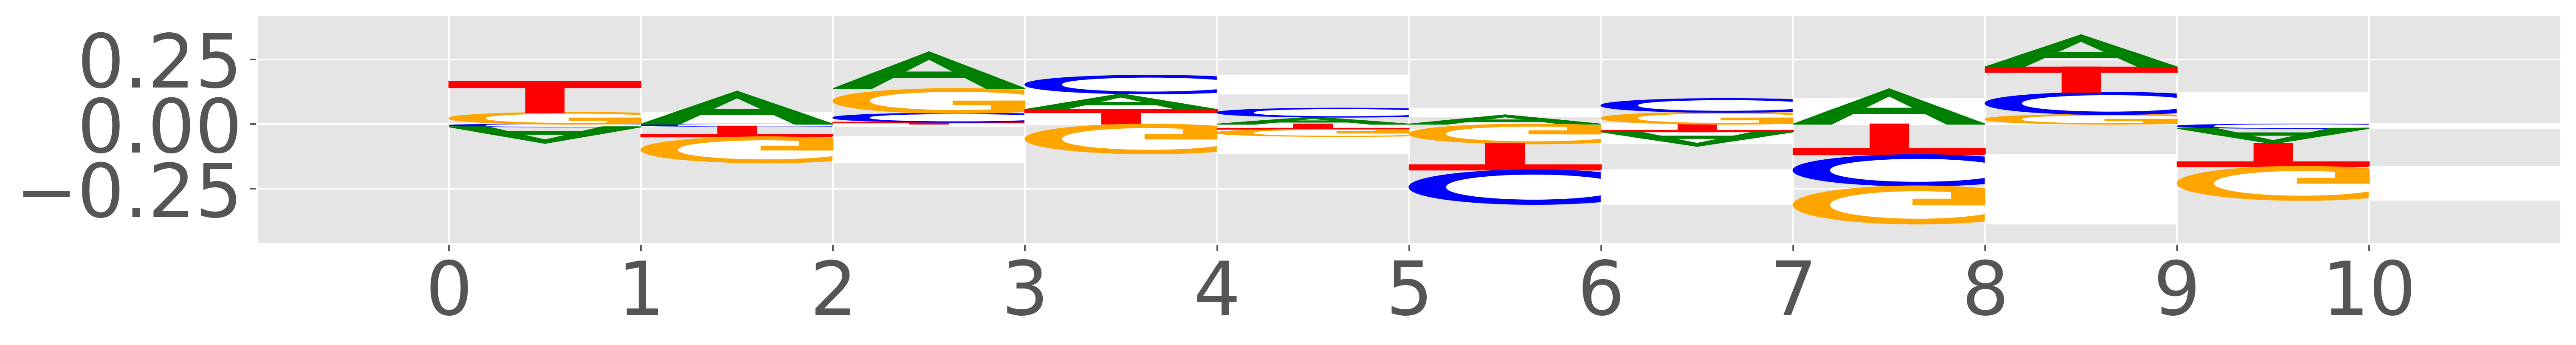

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

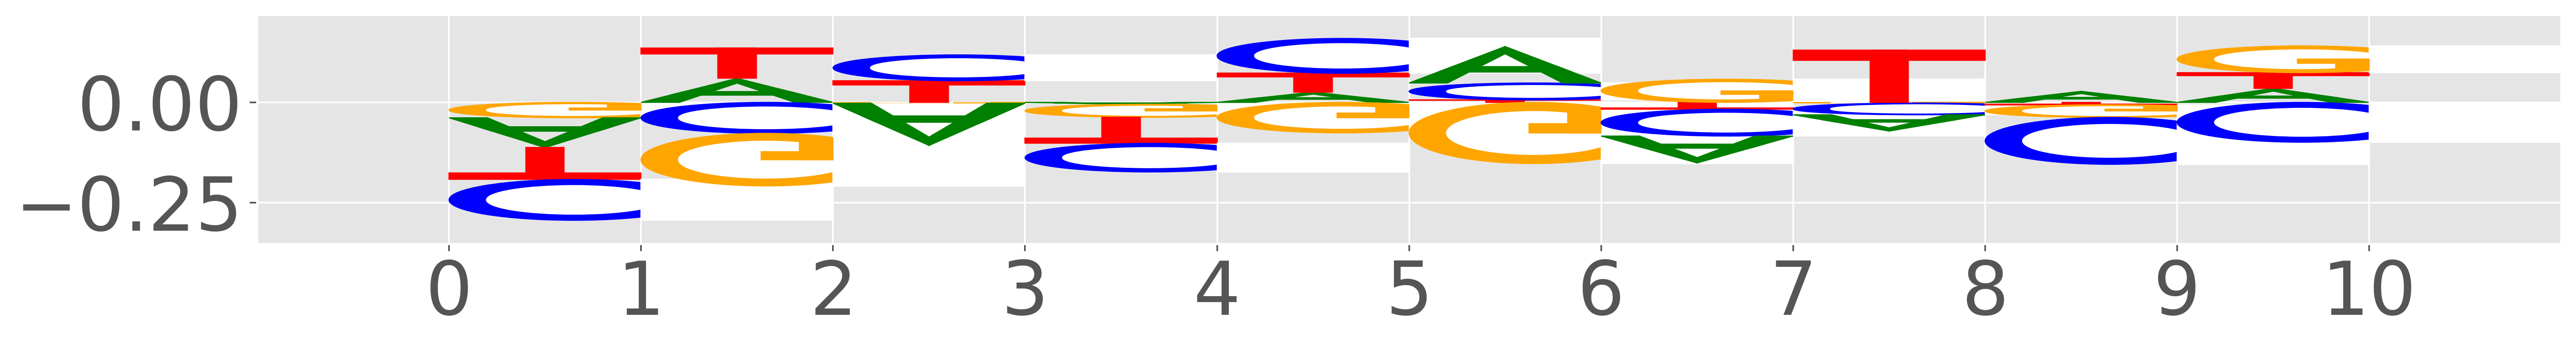

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

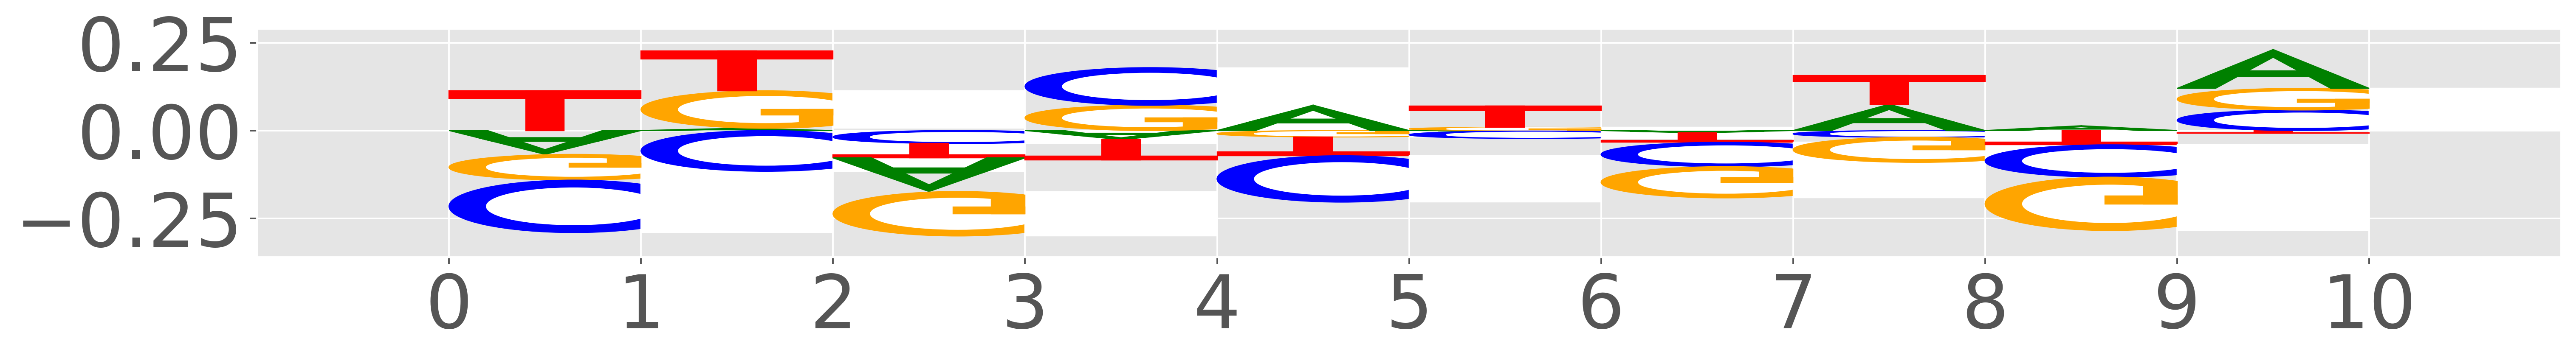

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

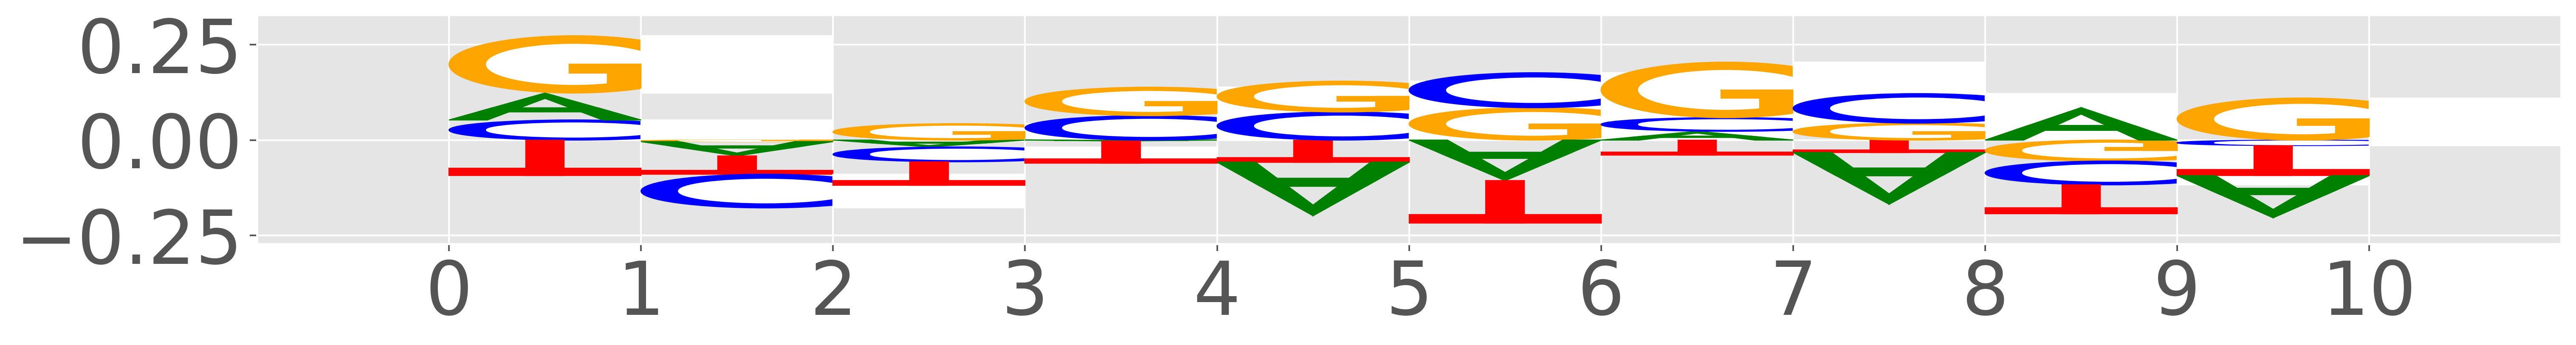

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

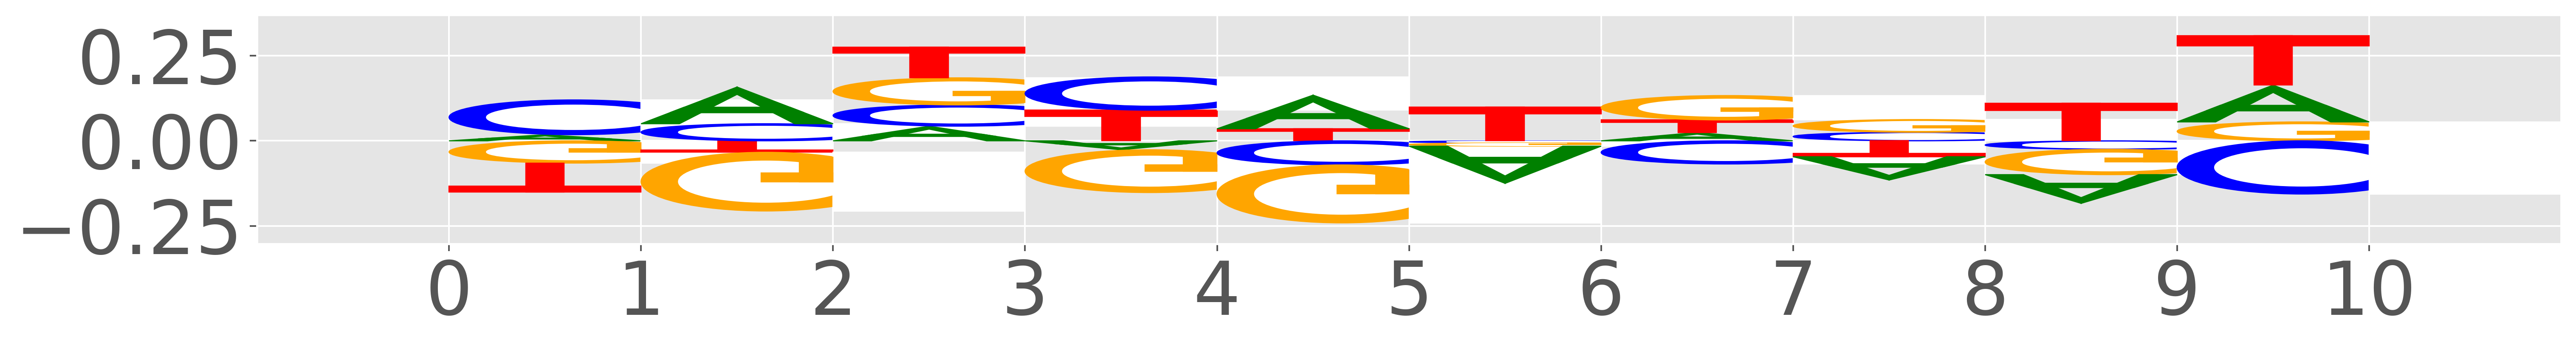

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

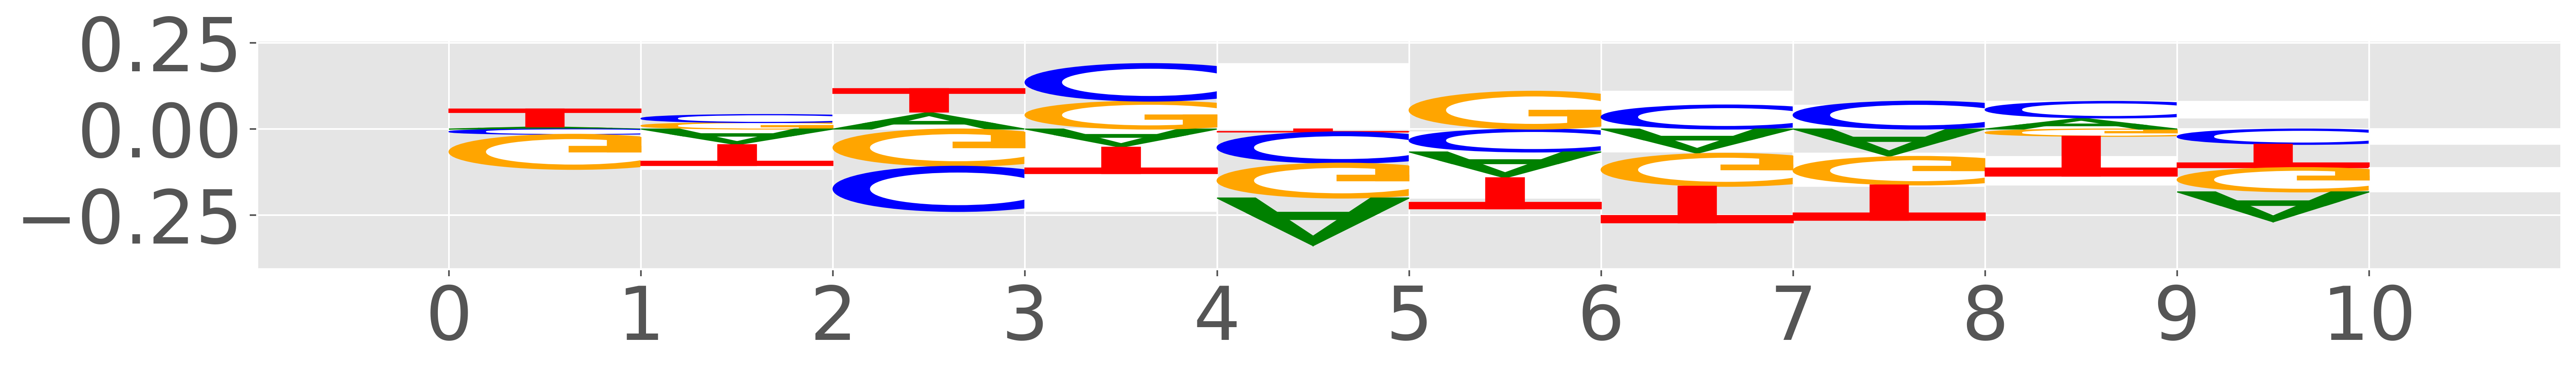

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

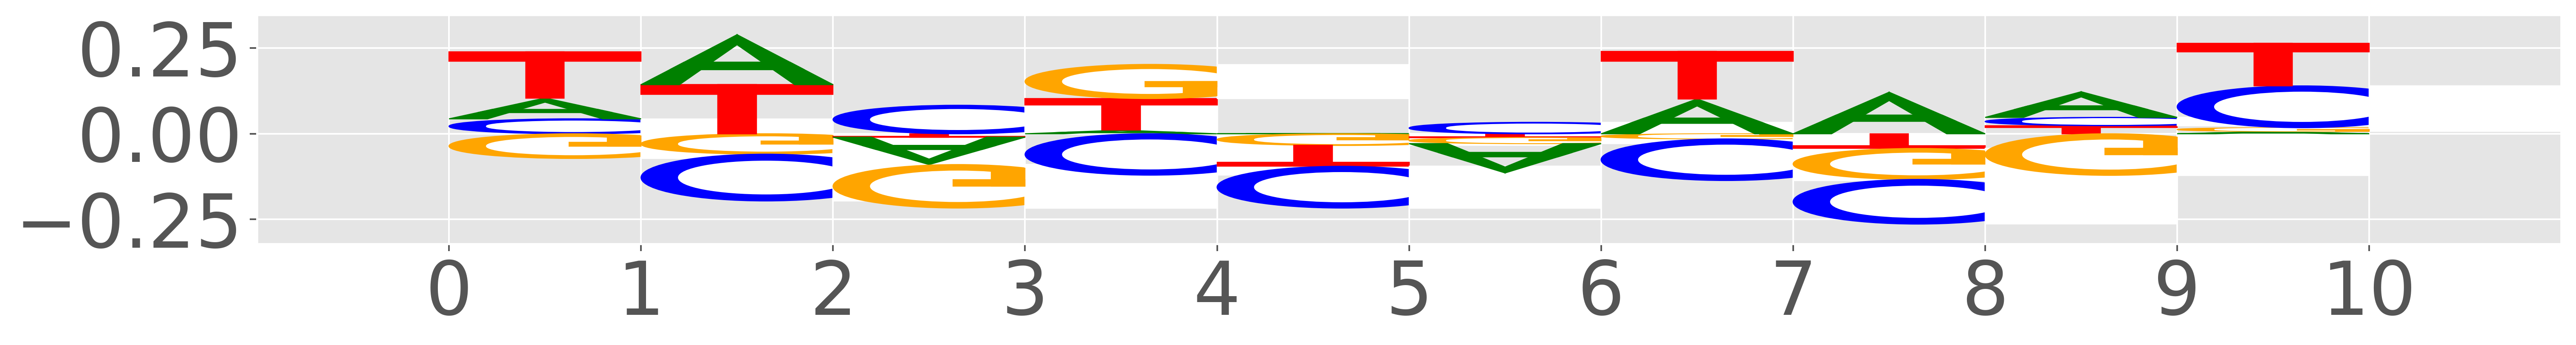

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

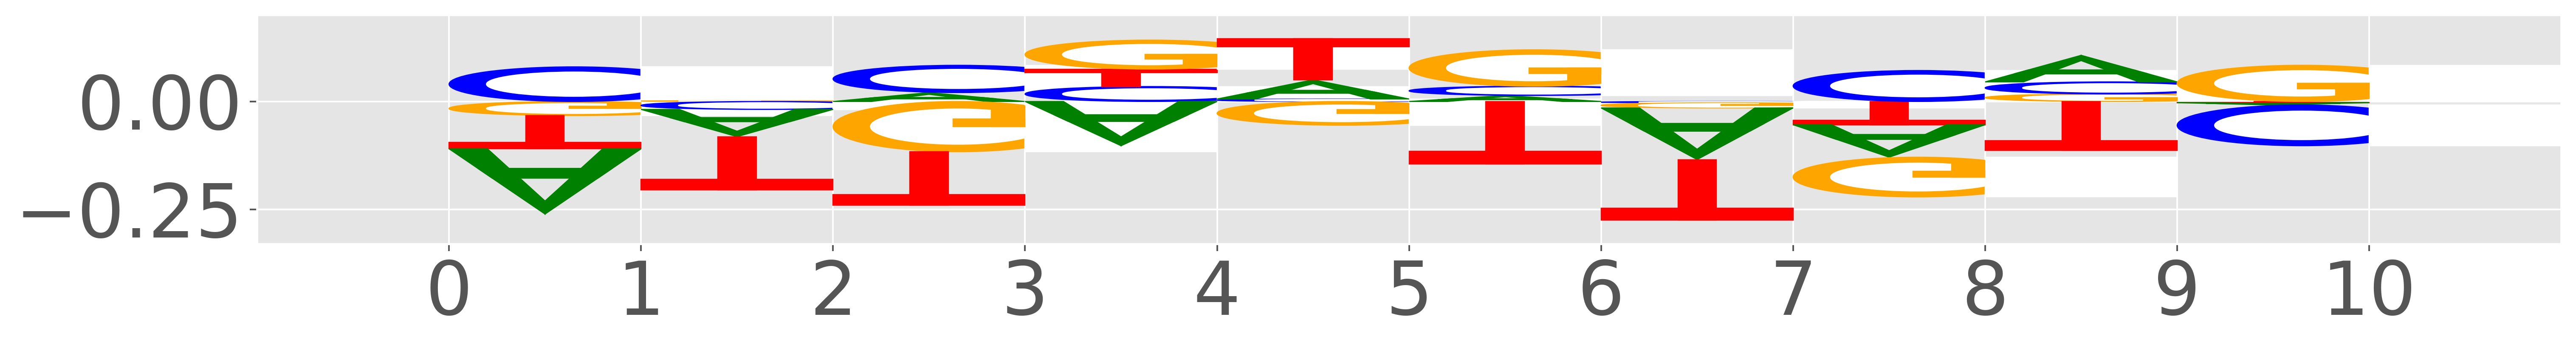

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

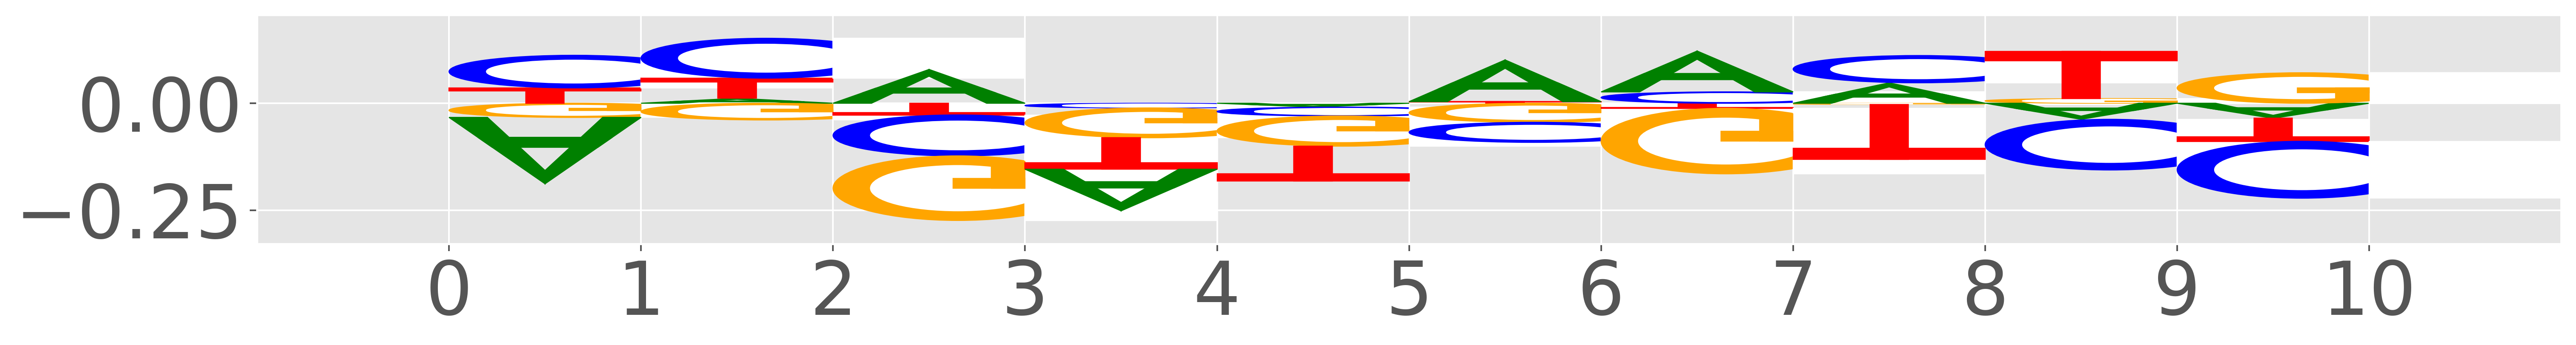

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

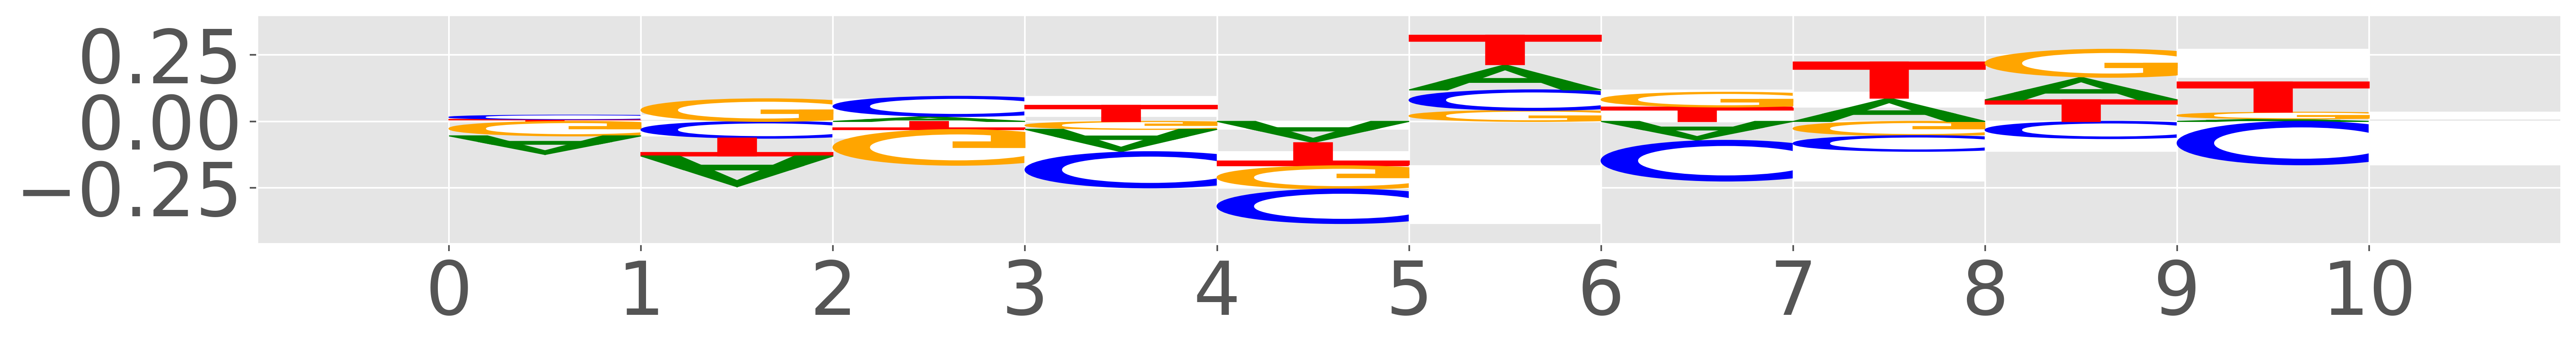

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

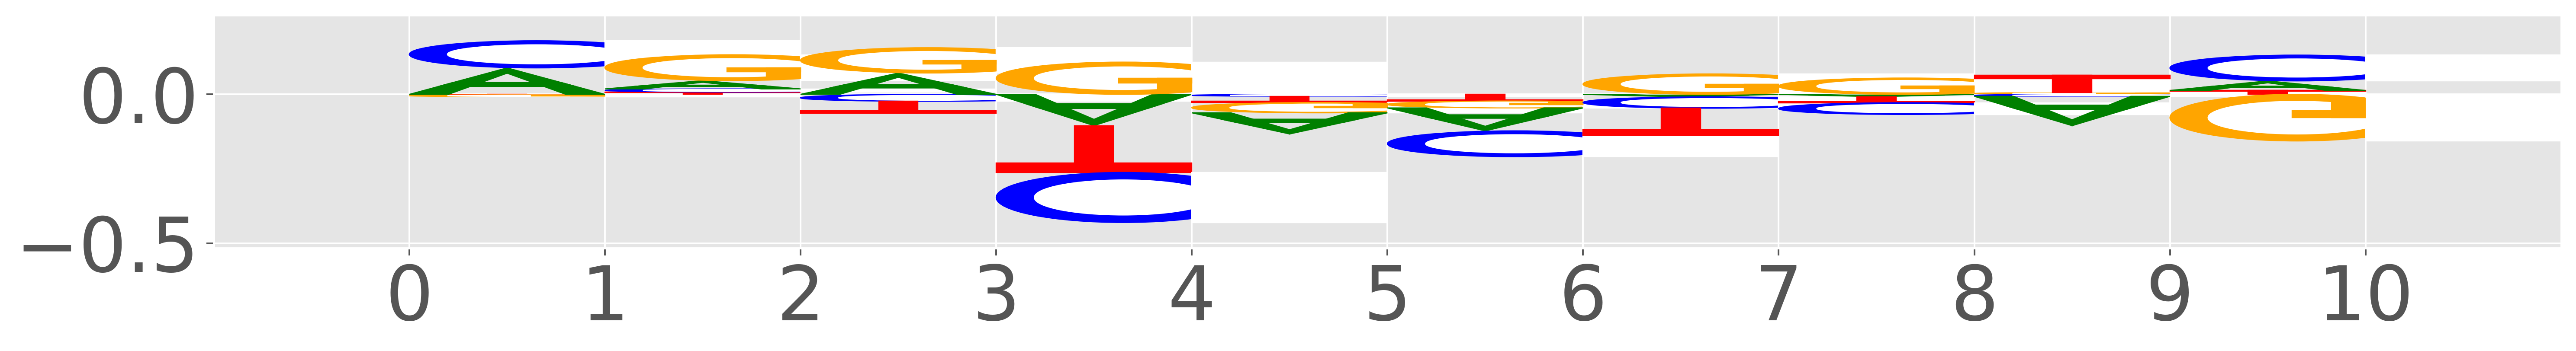

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

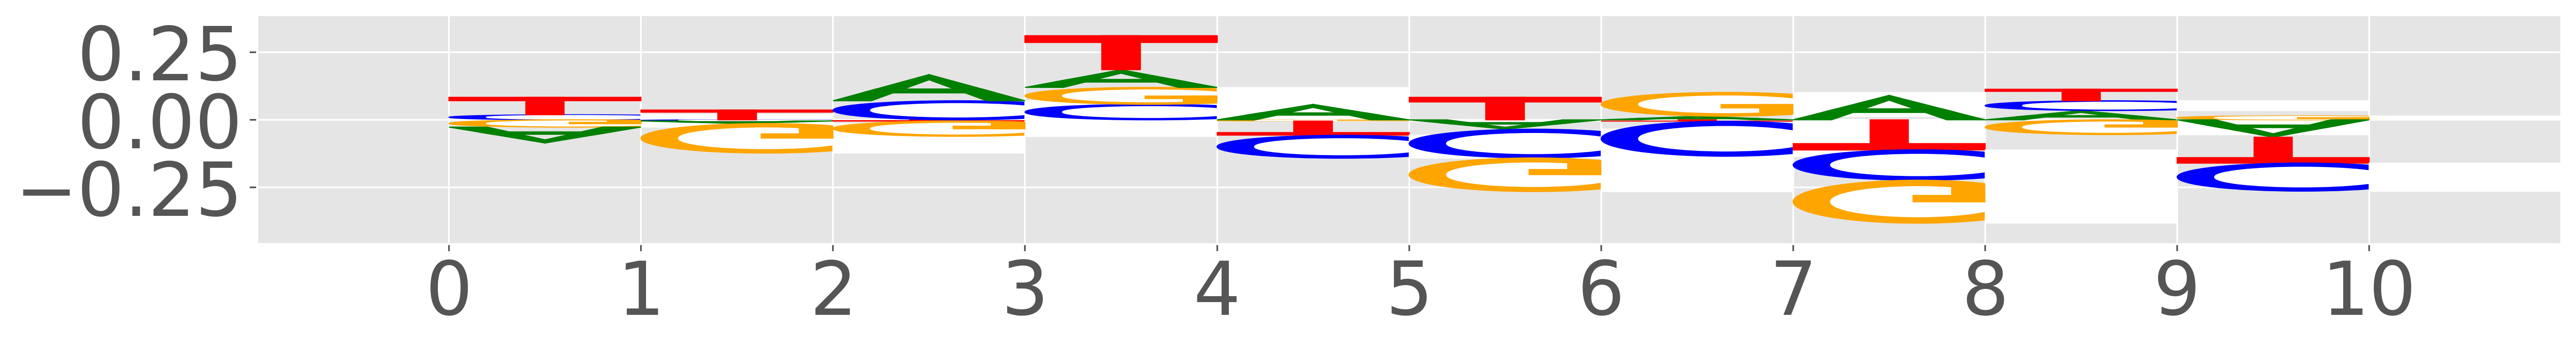

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

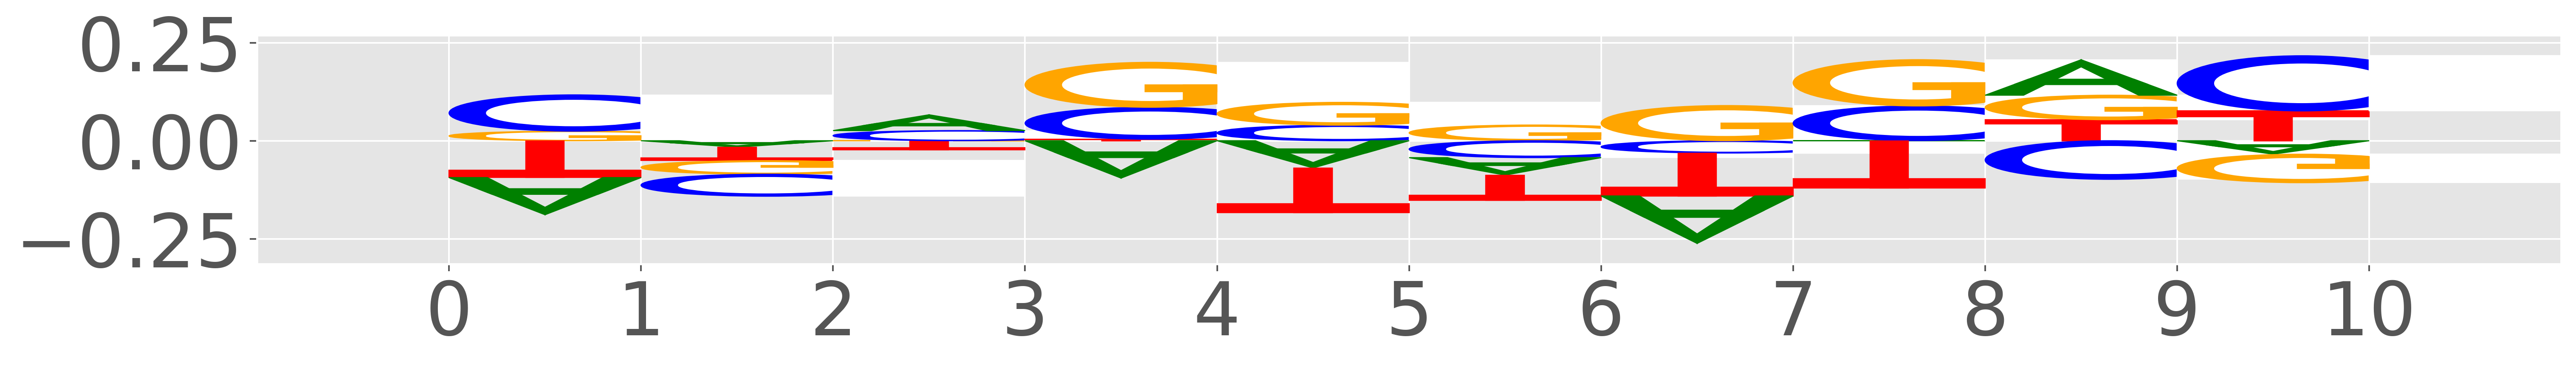

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

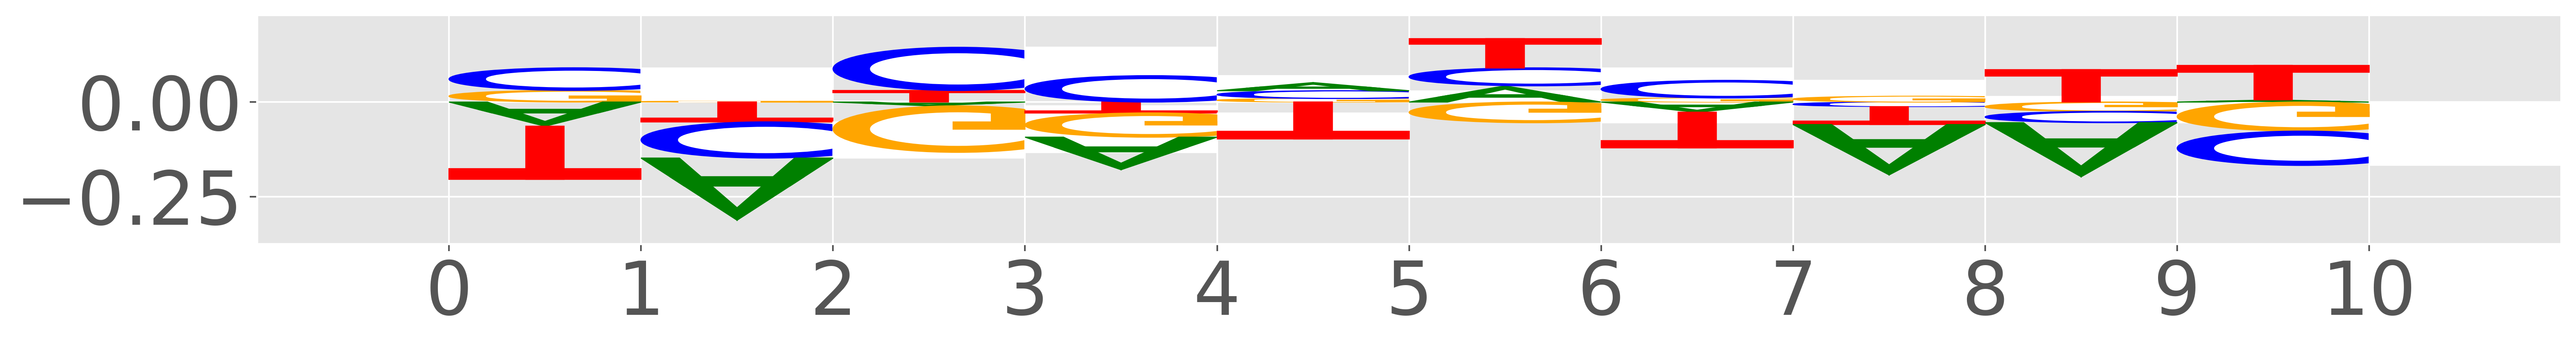

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

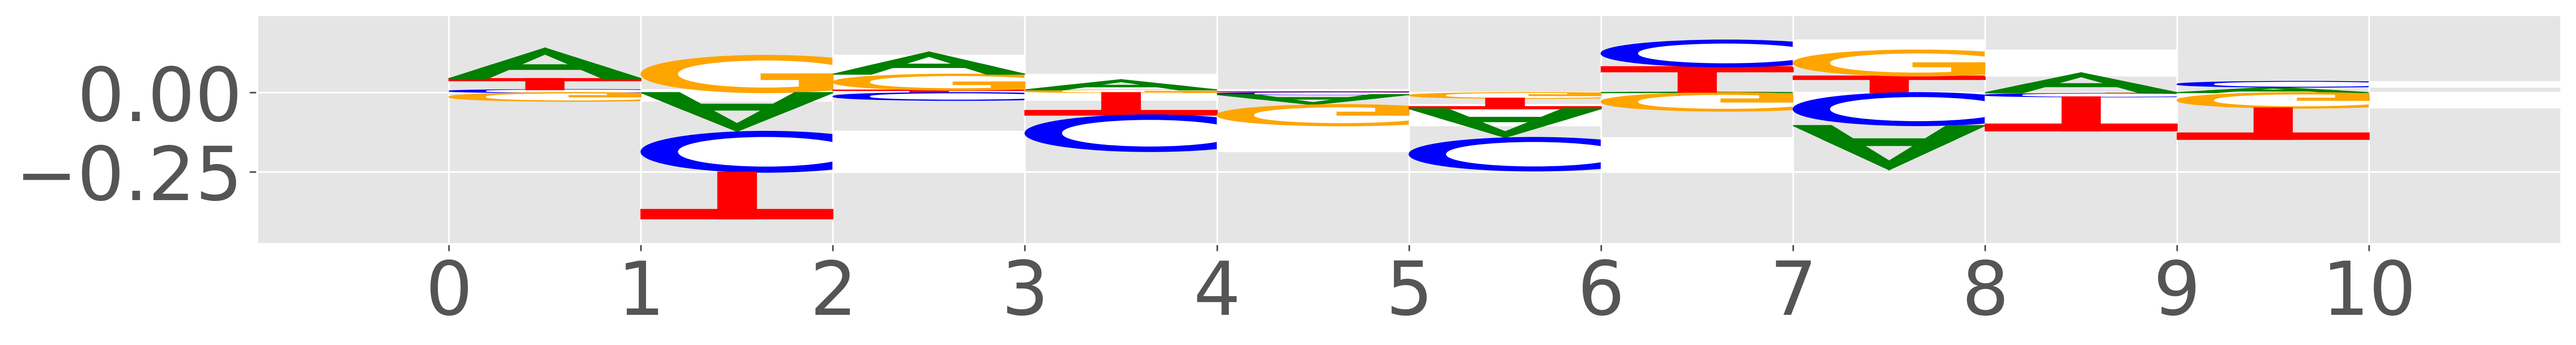

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

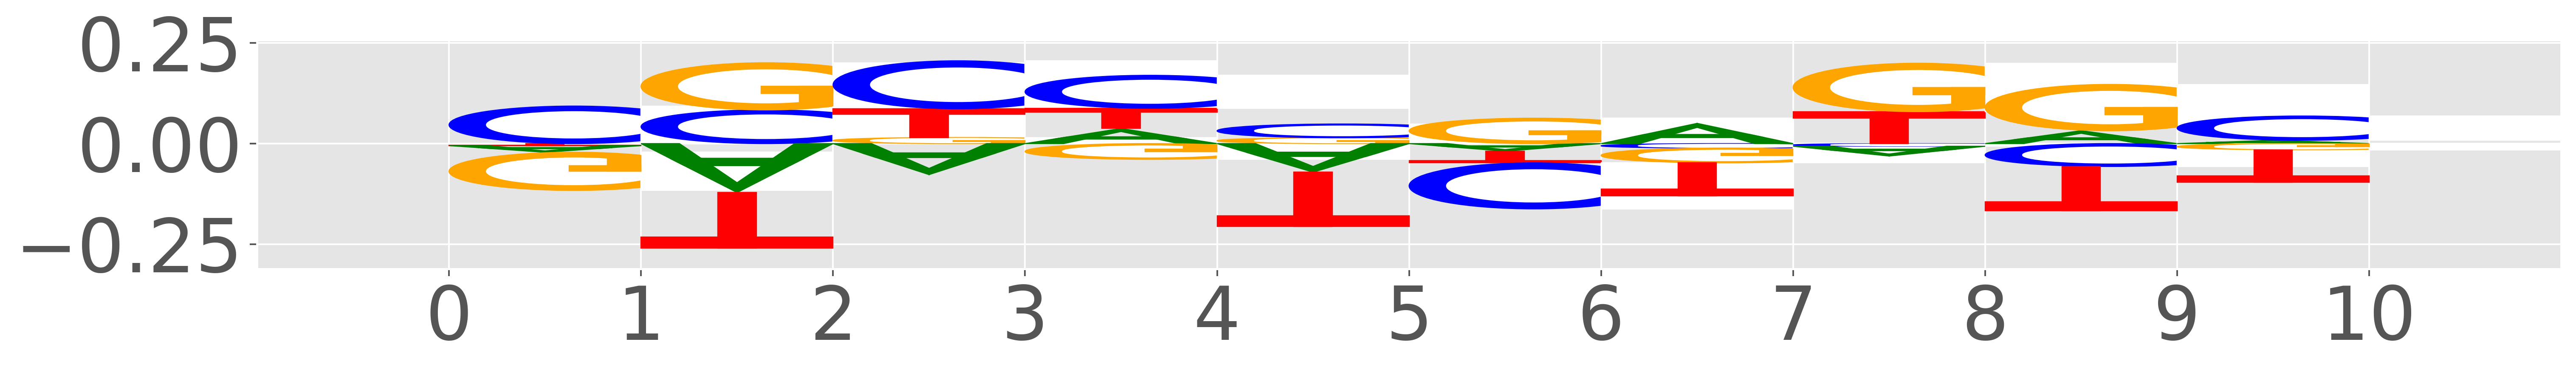

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

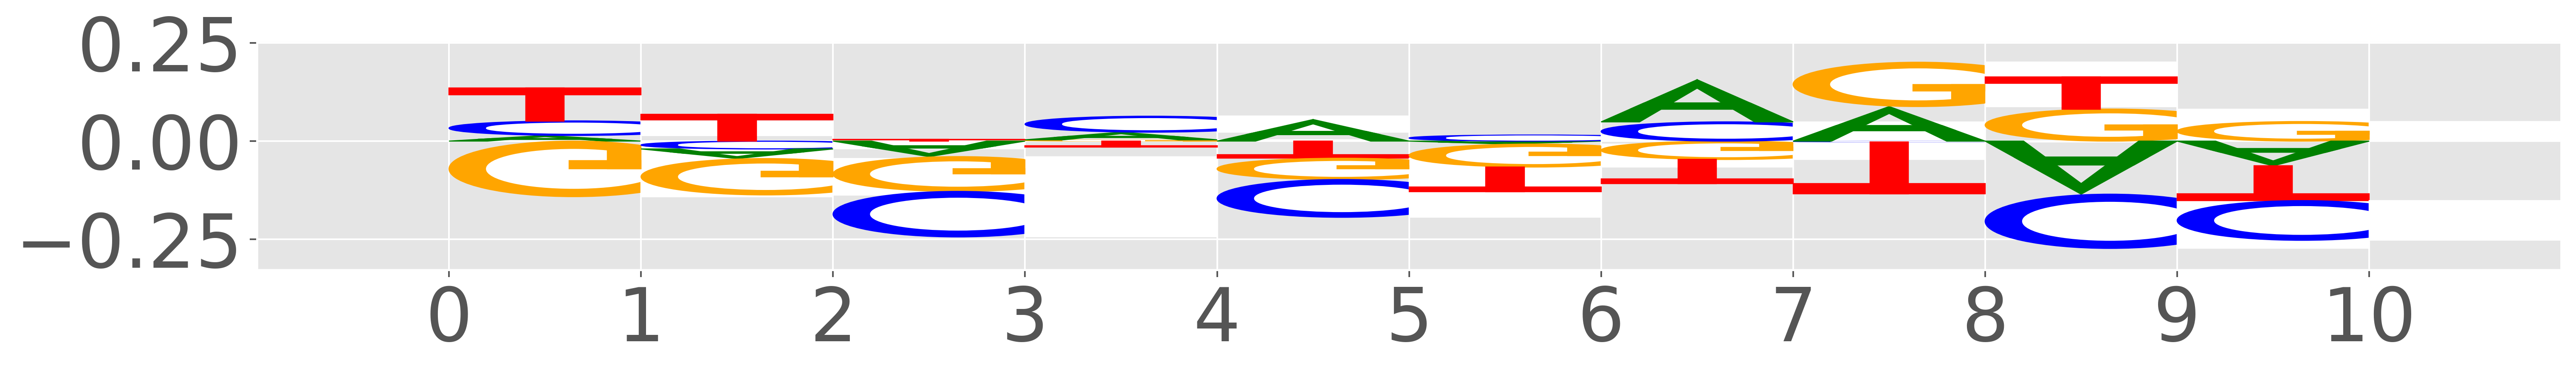

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

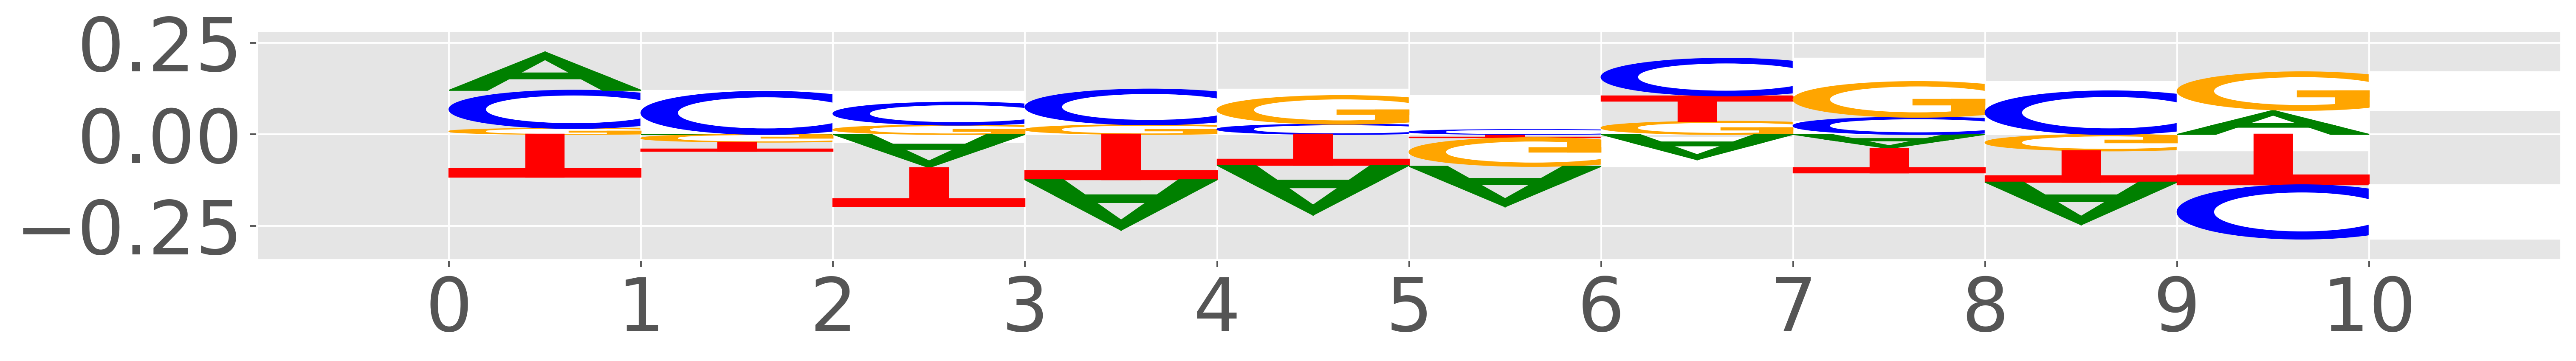

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

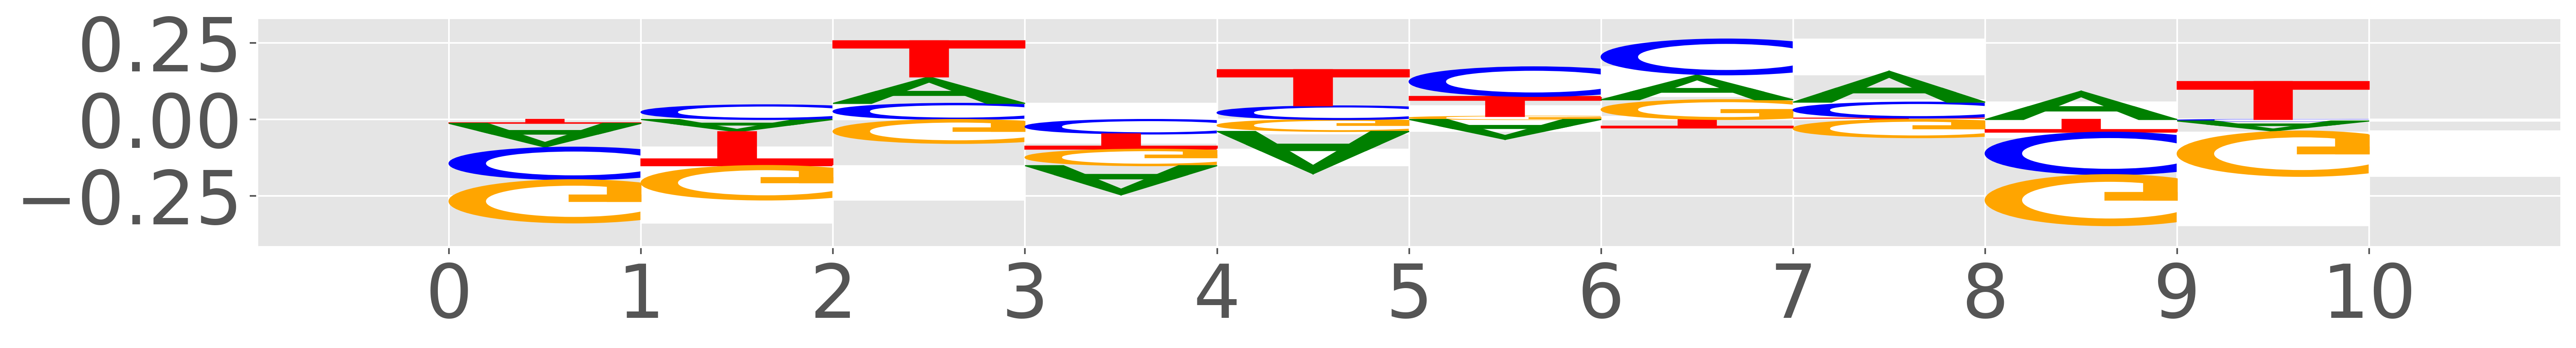

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

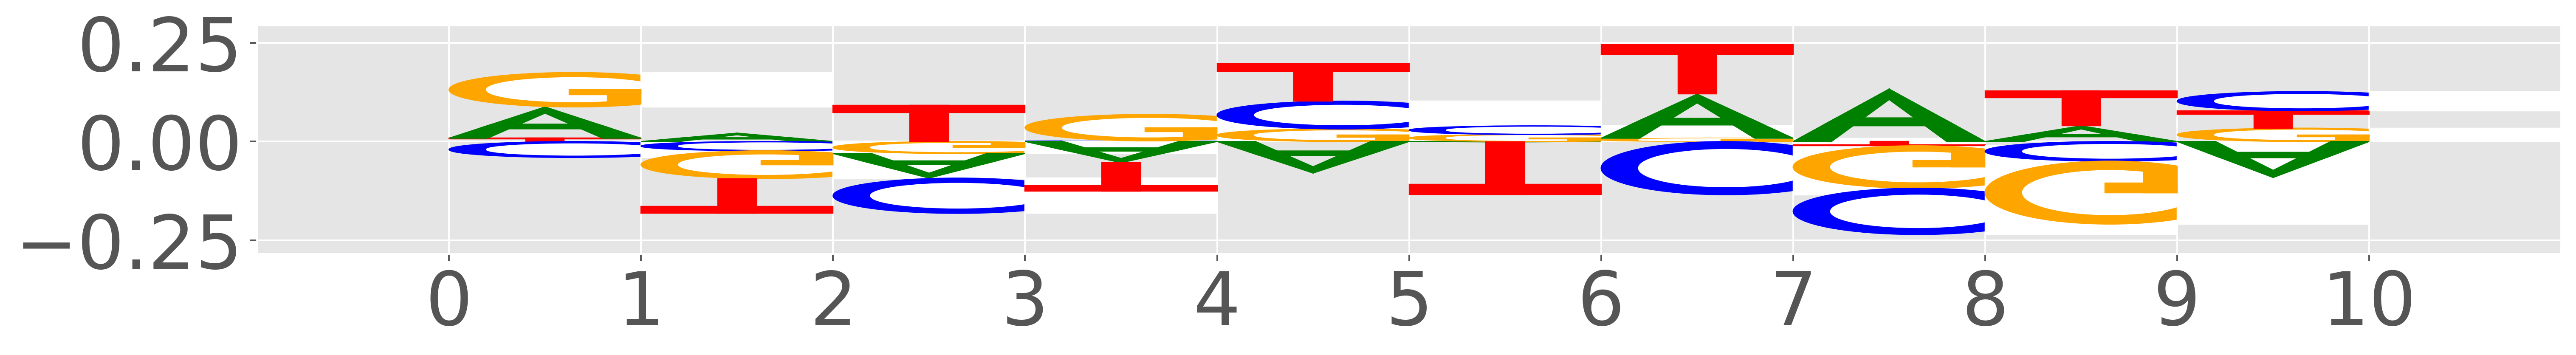

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

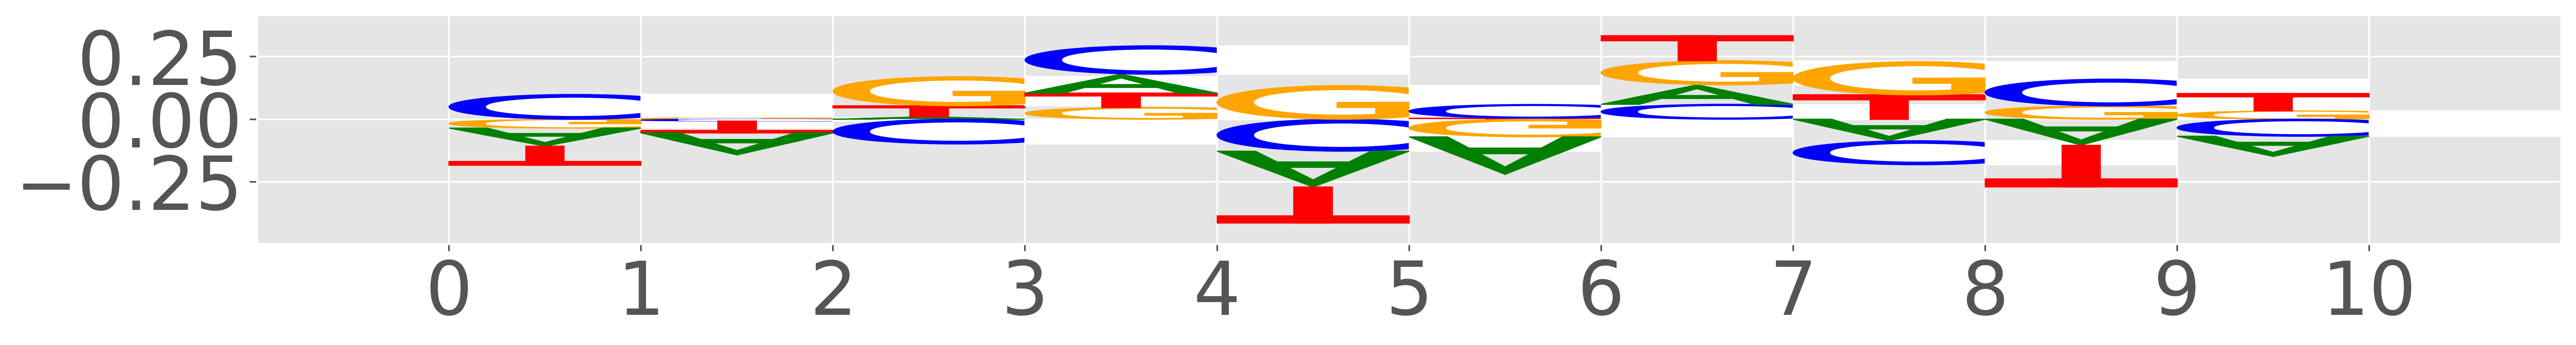

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

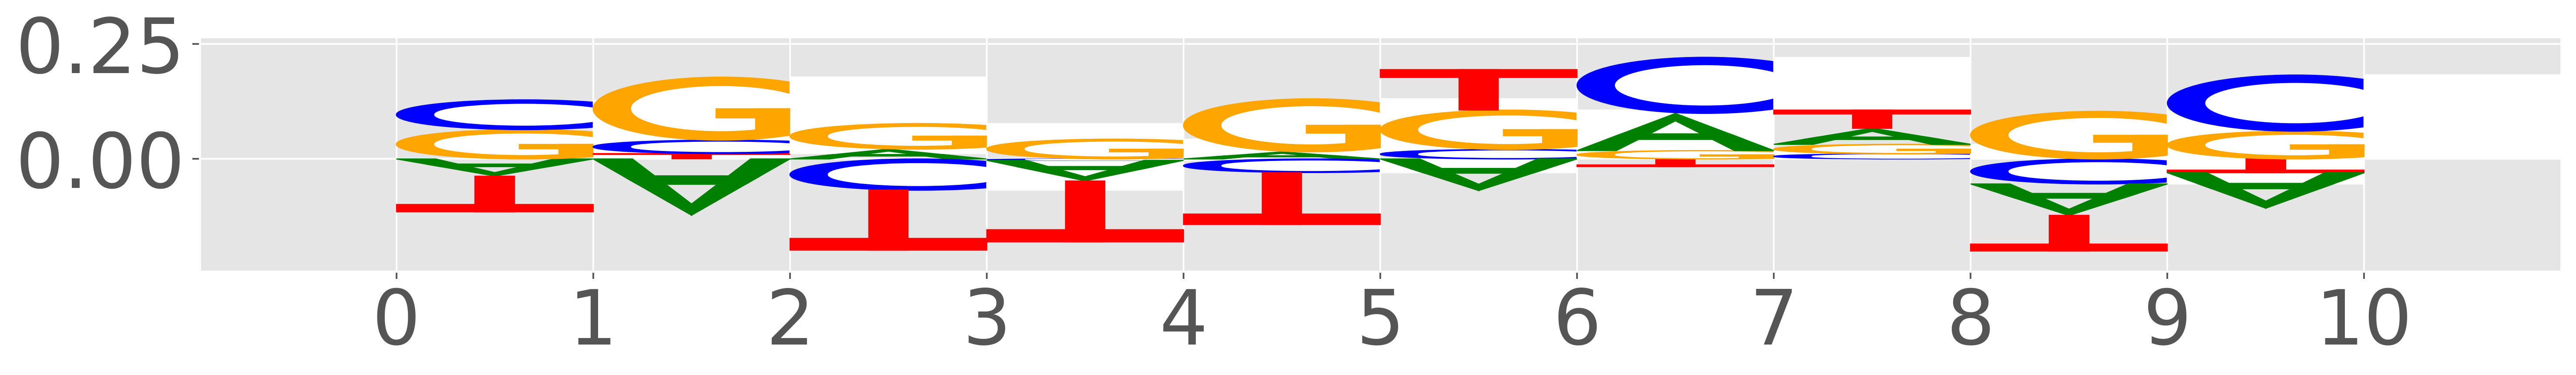

IndexError: index 32 is out of bounds for axis 2 with size 32

In [19]:
print(weights.shape) #channels * input * kernel_size

# tensorflow(kernel_size, input_shape, n_filters)
for i in range(64): #weights.shape[2]
  w = np.array(weights[:,:,i]) #having np.array is important!
  plot_weights(w)